<font size=6 color='purple'>**Separation plots**</font>

*Notes:* Initialization cells must be run before plotting, since they define functions, colors, and snapshot numbers


In [12]:
import h5py
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gd
from utils.paths import SetupPaths
from utils.get_summary_data import compile_summary
from utils.vectorCorrection import vectorCorrection as vector


paths = SetupPaths()

In [13]:
plt.show()
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in"})


# Initialization

In [14]:
# defining equivalent redshifts
zs = {"z":np.array([0,1,2,3,4]), 
      "zill":np.array([135,85,68,60,56]), 
      "ztng":np.array([99,50,33,25,22])}

In [15]:
# defining color palette for plotting
palette = {"Illustris dark": "#009292", "Illustris hydro": "#B6DAFF",
           "TNG dark": "#930200", "TNG hydro": "#FFB5DC"}


In [16]:
# make functions to get data at the requested snapshot
def get_primmask(primstells, size):
    if size == "dwarf":
        mask = (primstells > 0.01) & (primstells < 0.5)
    elif size == "massive":
        mask = (primstells > 0.5) & (primstells < 10)
    return mask

def get_groupmask(groupmass, size):
    if size == "dwarf":
        mask = (groupmass > 8) & (groupmass < 50)
    elif size == "massive":
        mask = (groupmass > 100) & (groupmass < 650)
    return mask

def get_sepmask(seps, key="default", **kwargs):
    """Note: key can be
    'high' -- sep > 100
    'low'  -- 10 < sep < 80
    'default' -- sep > 10
    'virial_low' -- sep < 1/2 Rvir
    'virial_high' -- sep > 1/2 Rvir
    'spec' -- specify the lower and upper bound with kwargs
    ---
    kwargs: **{"min": lower bound, "max": upper bound, "groupRadius":Group radius array}
    """
    seps = np.array(seps)
    minn = kwargs.pop("min",10)
    maxx = kwargs.pop("max",1000)
    rads = kwargs.pop("groupRadius",100*np.ones(len(seps)))
    
    if key == "high":
        mask = seps > 100
    elif key == "low":
        mask = (seps > 10) & (seps < 80)
    elif key == "default":
        mask = seps > 10
    elif key == "spec":
        mask = (seps > minn) & (seps < maxx)
    elif key =="virial_low":
        mask = (seps > 10) & (seps < 0.5*rads)
    elif key =="virial_high":
        mask = (seps > 0.5*rads)
    elif key =="virial":
        mask = (seps < rads) & (seps > 10)
    return mask

In [21]:
class EmptyFile(Exception): pass
class SkipRedshift(Exception): pass

def get_seps(sim, phys, size, sepmask="default", minn=10, maxx=1000, groupCut=False, median=False, errorprint=False, redshiftcutoff=True):    
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4
        
    redshifts = []  
    med_pairs, med_major, med_minor = [], [], []
    quart_pairs, quart_major, quart_minor = [], [], []
            
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_100.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['pairs'][phys]['Group ID']) == 0):    
                raise EmptyFile
                
                

            # grabbing the relevant values
            pairs = pair_data["pairs"][phys]

            pri_stell = np.array(pairs["Sub1 Stellar Mass"])
            sec_stell = np.array(pairs["Sub2 Stellar Mass"])
            grouprads = np.array(pairs["Group Radius"])
            seps = np.array(pairs["Separation"]) 
            
            # masks            
            paired_prims = get_primmask(pri_stell, size)
            paired_group = get_groupmask(np.array(pairs["Group Mass"]), size)
            paired_median = np.array( pairs['Realization'] )==-1
            paired_sepcut = get_sepmask(seps, key=sepmask, **{"min":minn,"max":maxx, "groupRadius":grouprads})

            majors = (sec_stell/pri_stell > 1/4)
            minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)
      
            paired_mask = paired_prims & paired_sepcut
        
            if groupCut:
                paired_mask = paired_mask & paired_group
        
            if median:
                paired_mask = paired_mask & paired_median

                major_mask = paired_mask & majors
                minor_mask = paired_mask & minors
                                
                med_pairs_snap = np.median(seps[paired_mask])
                med_major_snap = np.median(seps[major_mask])
                med_minor_snap = np.median(seps[minor_mask])
                quart_pairs_snap = [0,0]
                quart_major_snap = [0,0]
                quart_minor_snap = [0,0]
                                                      
            elif ~median: 
                paired_per_real = []
                major_per_real = []
                minor_per_real = []
                
                realizations = np.unique( np.array(pairs['Realization']) )
                
                for real in realizations:
                    paired_real = np.array( pairs['Realization'] ) == real
                    
                    paired_mask_real = paired_mask & paired_real
                    major_mask_real = paired_mask_real & majors
                    minor_mask_real = paired_mask_real & minors
                    
                    if np.count_nonzero(paired_mask_real) == 0:
                        pair_xx = 0
                        major_xx = 0
                        minor_xx = 0
                        
                    else: 
                        pair_xx = np.median(seps[paired_mask_real])
                        
                        if np.count_nonzero(major_mask_real) == 0:
                            major_xx = 0
                        else:
                            major_xx = np.median(seps[major_mask_real])
                            
                        if np.count_nonzero(minor_mask_real) == 0:
                            minor_xx = 0
                        else:
                            minor_xx = np.median(seps[minor_mask_real])
                        
                    paired_per_real.append( pair_xx )
                    major_per_real.append( major_xx )
                    minor_per_real.append( minor_xx )

                med_pairs_snap = np.median(paired_per_real)
                med_major_snap = np.median(major_per_real)
                med_minor_snap = np.median(minor_per_real)
                quart_pairs_snap = np.percentile( paired_per_real,[16,84] ) 
                quart_major_snap = np.percentile( major_per_real,[16,84] ) 
                quart_minor_snap = np.percentile( minor_per_real,[16,84] ) 
                
            redshifts.append( redshift )
            med_pairs.append( med_pairs_snap )
            med_major.append( med_major_snap )
            med_minor.append( med_minor_snap )


            quart_pairs.append( quart_pairs_snap )
            quart_major.append( quart_major_snap )
            quart_minor.append( quart_minor_snap )

        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                

                
    sep_dictionary = {"z":np.array(redshifts),
                        "All Median": np.array(med_pairs),
                        "Major Median": np.array(med_major),
                        "Minor Median":np.array(med_minor),
                        "All Quarts":np.array(quart_pairs),
                        "Major Quarts":np.array(quart_major),
                        "Minor Quarts":np.array(quart_minor)}
    
    return sep_dictionary

def get_seps_simstars(sim, size, sepmask="default", minn=10, maxx=1000, groupCut=False, errorprint=False, redshiftcutoff=True, **kwargs):    
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4
        
    redshifts = []  
    med_pairs, med_major, med_minor = [], [], []
    quart_pairs, quart_major, quart_minor = [], [], []
            
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_simstars.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['paired']["hydro"]['Group ID']) == 0):    
                raise EmptyFile
                
            # grabbing the relevant values
            pairs = pair_data["paired"]["hydro"]

            pri_stell = np.array(pairs["Sub1 Stellar Mass"])
            sec_stell = np.array(pairs["Sub2 Stellar Mass"])
            grouprads = np.array(pairs["Group Radius"])
            seps = np.array(pairs["Separation"]) 
            
            # masks            
            paired_prims = get_primmask(pri_stell, size)
            paired_group = get_groupmask(np.array(pairs["Group Mass"]), size)
            paired_median = np.array( pairs['Realization'] )==-1
            paired_sepcut = get_sepmask(seps, sepmask, **{"min":minn,"max":maxx, "groupRadius":grouprads})

            majors = (sec_stell/pri_stell > 1/4)
            minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)
      
            paired_mask = paired_prims & paired_sepcut
        
            if groupCut:
                paired_mask = paired_mask & paired_group
        
            paired_mask = paired_mask & paired_median

            major_mask = paired_mask & majors
            minor_mask = paired_mask & minors

            med_pairs_snap = np.median(seps[paired_mask])
            med_major_snap = np.median(seps[major_mask])
            med_minor_snap = np.median(seps[minor_mask])
            quart_pairs_snap = [0,0]
            quart_major_snap = [0,0]
            quart_minor_snap = [0,0]
                                                      
            
            redshifts.append( redshift )
            med_pairs.append( med_pairs_snap )
            med_major.append( med_major_snap )
            med_minor.append( med_minor_snap )


            quart_pairs.append( quart_pairs_snap )
            quart_major.append( quart_major_snap )
            quart_minor.append( quart_minor_snap )

        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
    sep_dictionary = {"z":np.array(redshifts),
                        "All Median": np.array(med_pairs),
                        "Major Median": np.array(med_major),
                        "Minor Median":np.array(med_minor),
                        "All Quarts":np.array(quart_pairs),
                        "Major Quarts":np.array(quart_major),
                        "Minor Quarts":np.array(quart_minor)}
    
    return sep_dictionary


# Separations 

## Plotting definitions to rerun quickly

In [11]:
def makeplot_all(size, **kwargs):
    
    start = time.time()
    illd = get_seps("Illustris", "dark", size, **kwarg_dict)
    end = time.time()
    print("Illustris dark:",end-start)
    
    start = time.time()
    illh = get_seps("Illustris", "hydro", size, **kwarg_dict)
    end = time.time()
    print("Illustris hydro:",end-start)

    start = time.time()
    tngd = get_seps("TNG", "dark", size, **kwarg_dict)
    end = time.time()
    print("TNG dark:",end-start)
    
    start = time.time()
    tngh = get_seps("TNG", "hydro", size, **kwarg_dict)
    end = time.time()
    print("TNG dark:",end-start)

    start = time.time()
    illsim = get_seps_simstars("Illustris", size, **kwarg_dict)
    end = time.time()
    print("Illustris sim:",end-start)
    
    start = time.time()
    tngsim = get_seps_simstars("TNG", size, **kwarg_dict)
    end = time.time()
    print("TNG sim:",end-start)
    
    if size == "dwarf":
        sizelabel = "d"
    elif size == "massive":
        sizelabel = "m"
        
    if kwargs["groupCut"]:
        groupcutlabel = "groupcut"
    else:
        groupcutlabel = "nogroupcut"
        
        
    # begin all pairs plot
    fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1],'wspace': 0.05,"hspace":0.02})

    axILL = ax[0][0]
    axTNG = ax[0][1]
    axilldiff = ax[1][0]
    axtngdiff = ax[1][1]

    ########################
    # Illustris plot first #
    ########################
    axILL.set(title="Illustris", ylabel="Separations")

    axILL.plot(illd['z'],illd['All Median'], color=palette["Illustris dark"], lw=3)
    axILL.plot(illh['z'],illh['All Median'], color=palette["Illustris hydro"], lw=3)

    axILL.fill_between(illd['z'], np.array(illd['All Quarts'])[:,0], np.array(illd['All Quarts'])[:,1],color=palette["Illustris dark"],alpha=1, label="Illustris dark")
    axILL.fill_between(illh['z'], np.array(illh['All Quarts'])[:,0], np.array(illh['All Quarts'])[:,1],color=palette["Illustris hydro"],alpha=1, label="Illustris hydro")

    axILL.plot(tngd['z'],tngd['All Median'], color='grey',alpha=0.2, lw=1)
    axILL.plot(tngh['z'],tngh["All Median"], color='grey',alpha=0.2, lw=1)

    axILL.plot(illsim['z'],illsim['All Median'], color='black', lw=2)


    ############
    # TNG plot #
    ############
    axTNG.set(title="TNG")
    axTNG.plot(tngd['z'],tngd['All Median'], color=palette["TNG dark"], lw=3)
    axTNG.plot(tngh['z'],tngh['All Median'], color=palette["TNG hydro"], lw=3)

    axTNG.fill_between(tngd['z'], np.array(tngd['All Quarts'])[:,0], np.array(tngd['All Quarts'])[:,1],color=palette["TNG dark"],alpha=1, label="TNG dark")
    axTNG.fill_between(tngh['z'], np.array(tngh['All Quarts'])[:,0], np.array(tngh['All Quarts'])[:,1],color=palette["TNG hydro"],alpha=1, label="TNG hydro")

    axTNG.plot(illd['z'],illd['All Median'], color='grey',alpha=0.2, lw=1)
    axTNG.plot(illh['z'],illh['All Median'], color='grey',alpha=0.2, lw=1)

    axTNG.plot(tngsim['z'],tngsim['All Median'], color='black', lw=2)


    ########################
    # Illustris difference #
    ########################
    axilldiff.set(ylabel=r"Difference")
    axilldiff.plot(illd['z'], np.array(illh['All Median'])-np.array(illd['All Median']), color=palette["Illustris hydro"], lw=3)
    # axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['unpaired'])-np.array(illh['unpaired']) )/np.array(illh['unpaired']), color=palette["Illustris hydro"], lw=2, linestyle='dotted')
    # axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['paired'])-np.array(illh['paired']) )/np.array(illd['paired']), color=palette["Illustris dark"], lw=2, linestyle='dashed')


    ########################
    # Illustris difference #
    ########################
    axtngdiff.plot(tngd['z'], np.array(tngh['All Median'])-np.array(tngd['All Median']), color=palette["TNG hydro"], lw=3)
    # axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['unpaired'])-np.array(tngh['unpaired']) )/np.array(tngh['unpaired']), color=palette["TNG hydro"], lw=2, linestyle='dotted')
    # axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['paired'])-np.array(tngh['paired']) )/np.array(tngd['paired']), color=palette["TNG dark"], lw=2, linestyle='dashed')
    # axtngdiff.set_ylim(0,23)

    axILL.legend(loc="upper right",fontsize=16)
    axTNG.legend(loc="upper right",fontsize=16)
    fig.supxlabel("Redshift")
    plt.savefig(f"../plots/separations/{groupcutlabel}_all_{kwarg_dict['sepmask']}_{sizelabel}.png",bbox_inches='tight',facecolor="white")
    plt.show()

  

starting massive with default
Illustris dark: 79.38112163543701
Illustris hydro: 67.97819113731384
TNG dark: 89.86716747283936
TNG dark: 75.5814836025238
Illustris sim: 1.9605951309204102
TNG sim: 1.6713976860046387


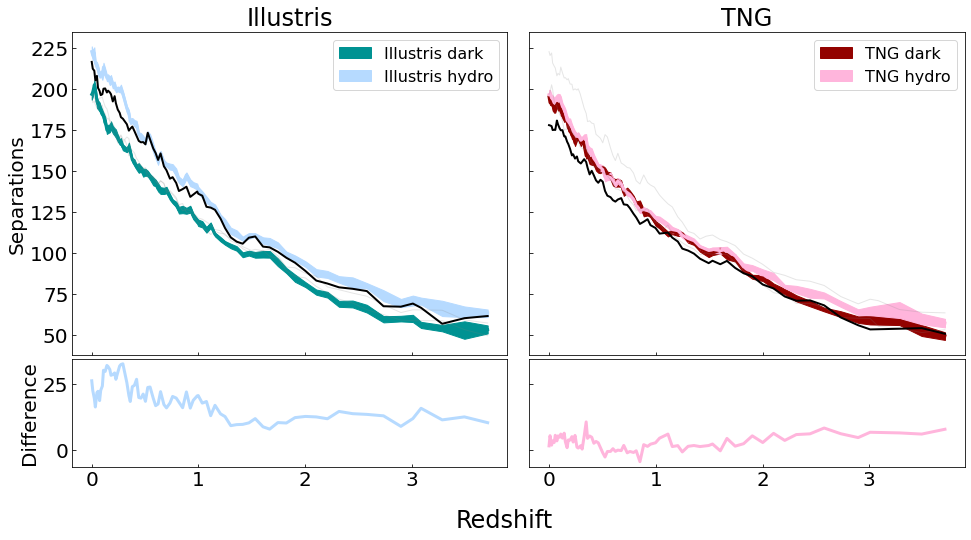

done with default
starting massive with low
Illustris dark: 83.61776733398438
Illustris hydro: 65.41966557502747
TNG dark: 81.81849217414856
TNG dark: 72.40248465538025
Illustris sim: 0.9914252758026123
TNG sim: 0.849931001663208


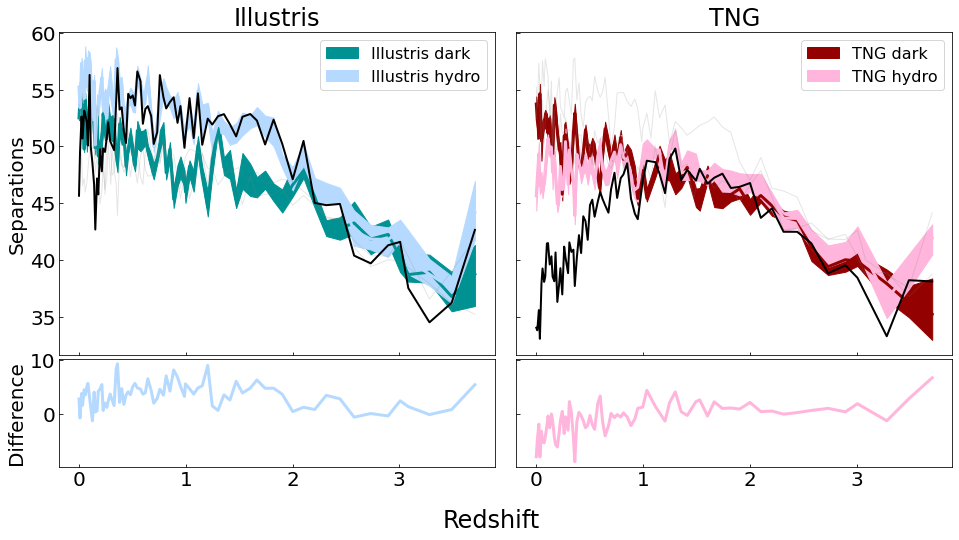

done with low
starting massive with high
Illustris dark: 68.17317771911621
Illustris hydro: 63.88558912277222
TNG dark: 80.362802028656
TNG dark: 70.14362144470215
Illustris sim: 0.9634532928466797
TNG sim: 1.1766386032104492


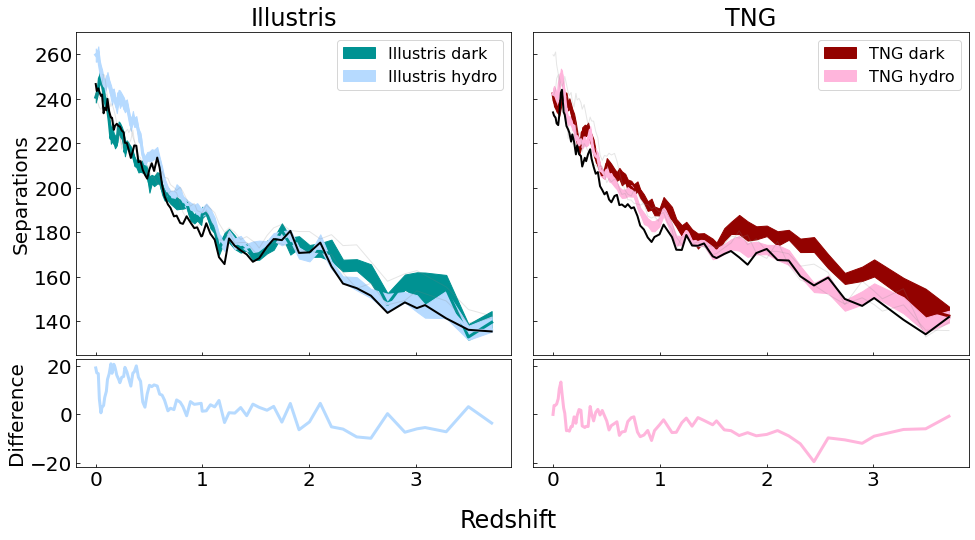

done with high
starting massive with virial_low
Illustris dark: 67.67165517807007
Illustris hydro: 63.104623794555664
TNG dark: 80.04248547554016
TNG dark: 70.61643290519714
Illustris sim: 0.9499435424804688
TNG sim: 0.8284692764282227


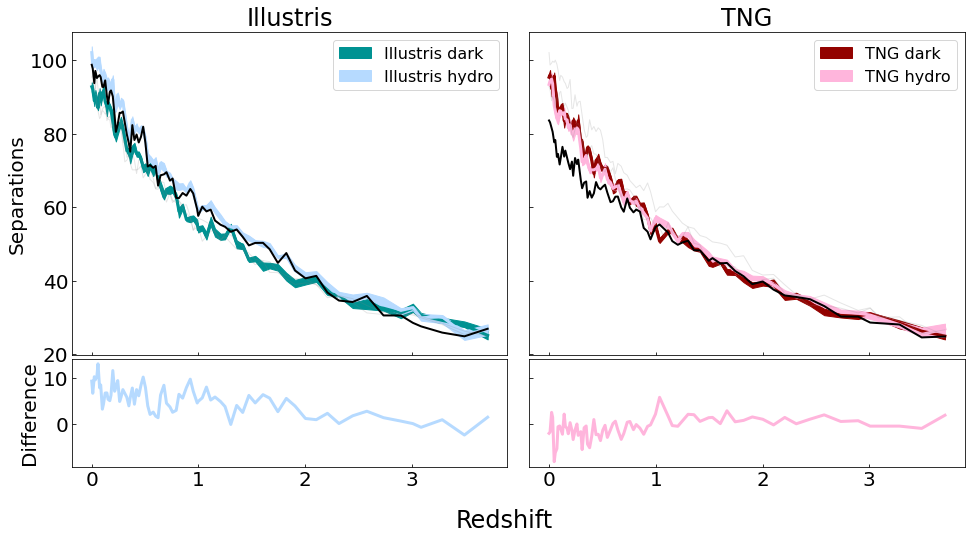

done with virial_low
starting massive with virial_high
TNG dark: 80.6186306476593
TNG dark: 70.145263671875
Illustris sim: 0.9193897247314453
TNG sim: 0.8356332778930664


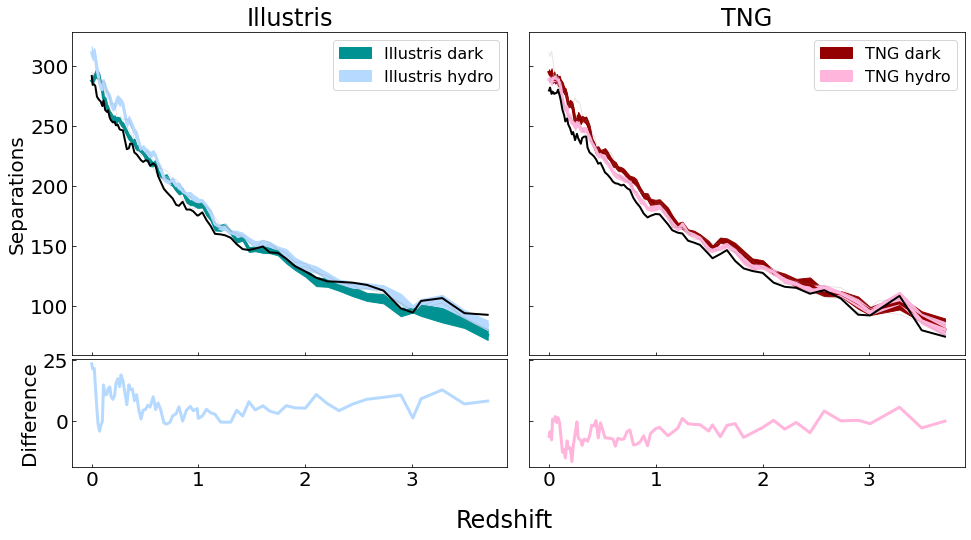

done with virial_high


In [12]:
kwarg_dict_def = {"groupCut": True, 
              "median":False, 
              "errorprint":False, 
              "redshiftcutoff":True}

size = "massive"
for septype in ["default","low", "high", "virial_low","virial_high"]:
    print(f"starting {size} with {septype}")
    kwarg_dict = {**kwarg_dict_def,
                  "sepmask":septype}
    
    makeplot_all(size, **kwarg_dict)
    
    print(f"done with {septype}")

# Major minor plots

In [22]:
# function to make major+minor sep plots
def makeplot_seps(size, **kwargs):
    illd = get_seps("Illustris", "dark", size, **kwarg_dict)
    illh = get_seps("Illustris", "hydro", size, **kwarg_dict)

    tngd = get_seps("TNG", "dark", size, **kwarg_dict)
    tngh = get_seps("TNG", "hydro", size, **kwarg_dict)

    illsim = get_seps_simstars("Illustris", size, **kwarg_dict)
    tngsim = get_seps_simstars("TNG", size, **kwarg_dict)
    
    if size == "dwarf":
        sizelabel = "d"
    elif size == "massive":
        sizelabel = "m"
        
    if kwargs["groupCut"]:
        groupcutlabel = "groupcut"
    else:
        groupcutlabel = "nogroupcut"
        
         
    # begin major minor plot:
    fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.3,3,1],'wspace': 0.05,"hspace":0.02})

    # blank = ax[2]
    for i in ax[2]:
        i.spines['right'].set_visible(False)
        i.spines['top'].set_visible(False)
        i.spines['left'].set_visible(False)
        i.spines['bottom'].set_visible(False)
        i.get_xaxis().set_visible(False)
        i.get_yaxis().set_visible(False)

    axillmaj = ax[0][0]
    axillmin = ax[0][1]

    axillmajdiff = ax[1][0]
    axillmindiff = ax[1][1]

    axtngmaj = ax[3][0]
    axtngmin = ax[3][1]

    axtngmajdiff = ax[4][0]
    axtngmindiff = ax[4][1]

    al = 0.5

    ###################
    # Illustris major #
    ###################
    axillmaj.set(title="Major", ylabel="Separations")
    axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
    axillmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)
    axillmaj.plot(illsim['z'],illsim['Major Median'], color='black', lw=1)

    axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
    axillmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

    axillmaj.plot(tngd['z'],tngd['Major Median'], color='grey',alpha=0.2, lw=1)
    axillmaj.plot(tngh['z'],tngh["Major Median"], color='grey',alpha=0.2, lw=1)

    axillmajdiff.set(ylabel=r"Diff.")
    lowdiff = np.array(illh['Major Quarts'])[:,0]-np.array(illd['Major Quarts'])[:,1]
    highdiff = np.array(illh['Major Quarts'])[:,1]-np.array(illd['Major Quarts'])[:,0]

    axillmajdiff.plot(illd['z'], (np.array(illh['Major Median'])-np.array(illd['Major Median']) ), color=palette["Illustris hydro"], lw=3)
    axillmajdiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Dark")


    ###################
    # Illustris minor #
    ###################
    axillmin.set(title="Minor")
    axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
    axillmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)
    axillmin.plot(illsim['z'],illsim['Minor Median'], color='black', lw=1)

    axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
    axillmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

    axillmin.plot(tngd['z'],tngd['Minor Median'], color='grey',alpha=0.2, lw=1)
    axillmin.plot(tngh['z'],tngh["Minor Median"], color='grey',alpha=0.2, lw=1)

    lowdiff = np.array(illh['Minor Quarts'])[:,0]-np.array(illd['Minor Quarts'])[:,1]
    highdiff = np.array(illh['Minor Quarts'])[:,1]-np.array(illd['Minor Quarts'])[:,0]
    axillmindiff.plot(illd['z'], (np.array(illh['Minor Median'])-np.array(illd['Minor Median']) ), color=palette["Illustris hydro"], lw=3)
    axillmindiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Hydro")


    #############
    # TNG major #
    #############
    axtngmaj.set(ylabel="Separations")
    axtngmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)
    axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)
    axtngmaj.plot(tngsim['z'],tngsim['Major Median'], color='black', lw=1)

    axtngmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
    axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

    axtngmaj.plot(illd['z'],illd['Major Median'], color='grey',alpha=0.2, lw=1)
    axtngmaj.plot(illh['z'],illh["Major Median"], color='grey',alpha=0.2, lw=1)

    axtngmajdiff.set(ylabel=r"Diff.")
    lowdiff = np.array(tngh['Major Quarts'])[:,0]-np.array(tngd['Major Quarts'])[:,1]
    highdiff = np.array(tngh['Major Quarts'])[:,1]-np.array(tngd['Major Quarts'])[:,0]

    axtngmajdiff.plot(tngd['z'], (np.array(tngh['Major Median'])-np.array(tngd['Major Median']) ), color=palette["TNG hydro"], lw=3)
    axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


    #############
    # TNG minor #
    #############
    axtngmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)
    axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)
    axtngmin.plot(tngsim['z'],tngsim['Minor Median'], color='black', lw=1)

    axtngmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
    axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

    axtngmin.plot(illd['z'],illd['Minor Median'], color='grey',alpha=0.2, lw=1)
    axtngmin.plot(illh['z'],illh["Minor Median"], color='grey',alpha=0.2, lw=1)

    lowdiff = np.array(tngh['Minor Quarts'])[:,0]-np.array(tngd['Minor Quarts'])[:,1]
    highdiff = np.array(tngh['Minor Quarts'])[:,1]-np.array(tngd['Minor Quarts'])[:,0]

    axtngmindiff.plot(tngd['z'], (np.array(tngh['Minor Median'])-np.array(tngd['Minor Median']) ), color=palette["TNG hydro"], lw=3)
    axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


    #############
    #############
    axillmin.legend(title="Illustris",loc="upper right",fontsize=16)
    axtngmin.legend(title="TNG",loc="upper right",fontsize=16)
    fig.supxlabel("Redshift",y=0.08)
    plt.savefig(f"../plots/separations/{groupcutlabel}_majorminor_{kwarg_dict['sepmask']}_{sizelabel}_100.png",bbox_inches='tight',facecolor="white")
    plt.show()
    

starting massive with virial


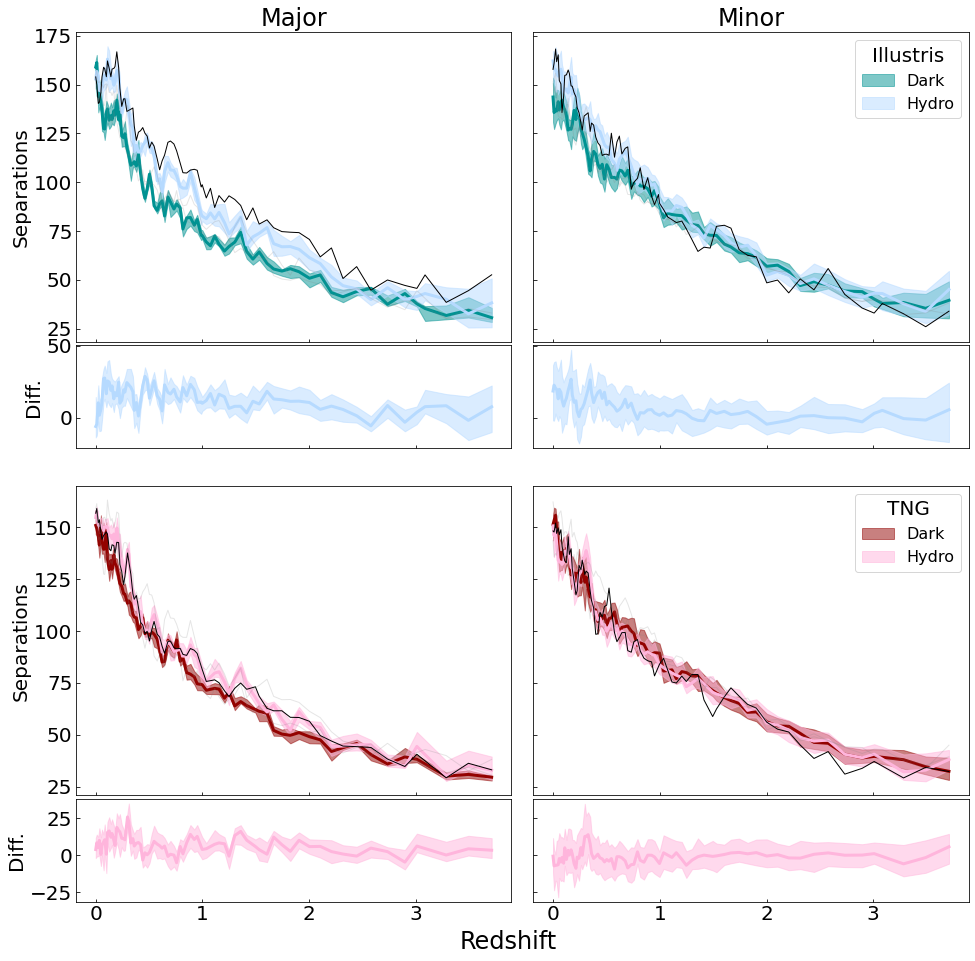

done with virial
starting massive with virial_low


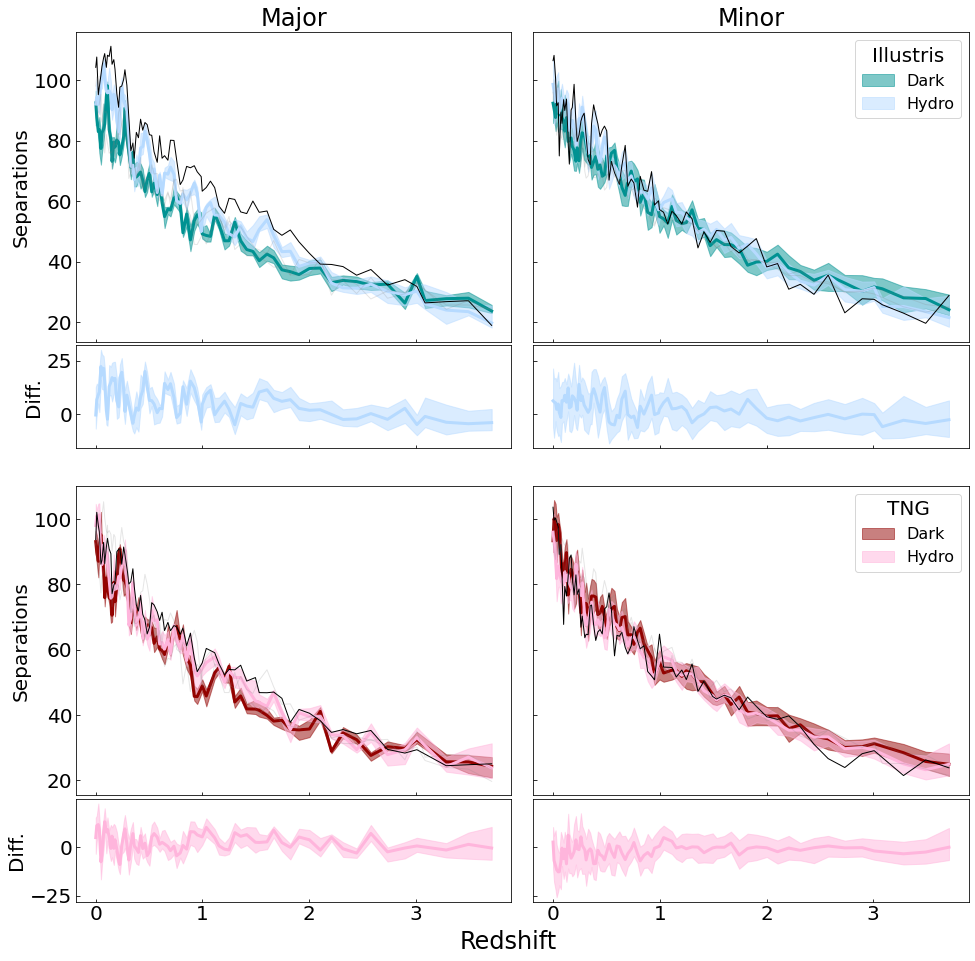

done with virial_low
starting massive with virial_high


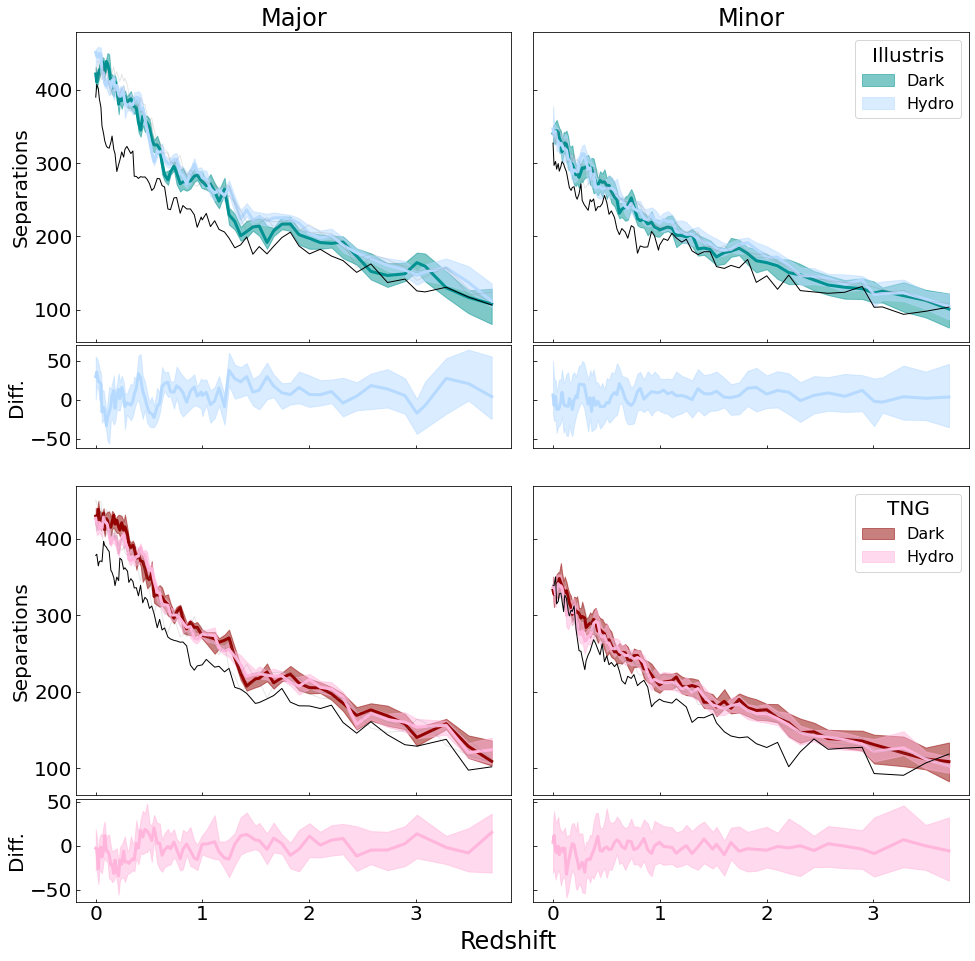

done with virial_high


In [23]:
kwarg_dict_def = {"groupCut": True, 
              "median":False, 
              "errorprint":False, 
              "redshiftcutoff":True}

size = "massive"
for septype in ["virial", "virial_low","virial_high"]:#,"default","low", "high",]:
    print(f"starting {size} with {septype}")
    kwarg_dict = {**kwarg_dict_def,
                  "sepmask":septype}
    makeplot_seps(size, **kwarg_dict)
    print(f"done with {septype}")

starting dwarf with virial


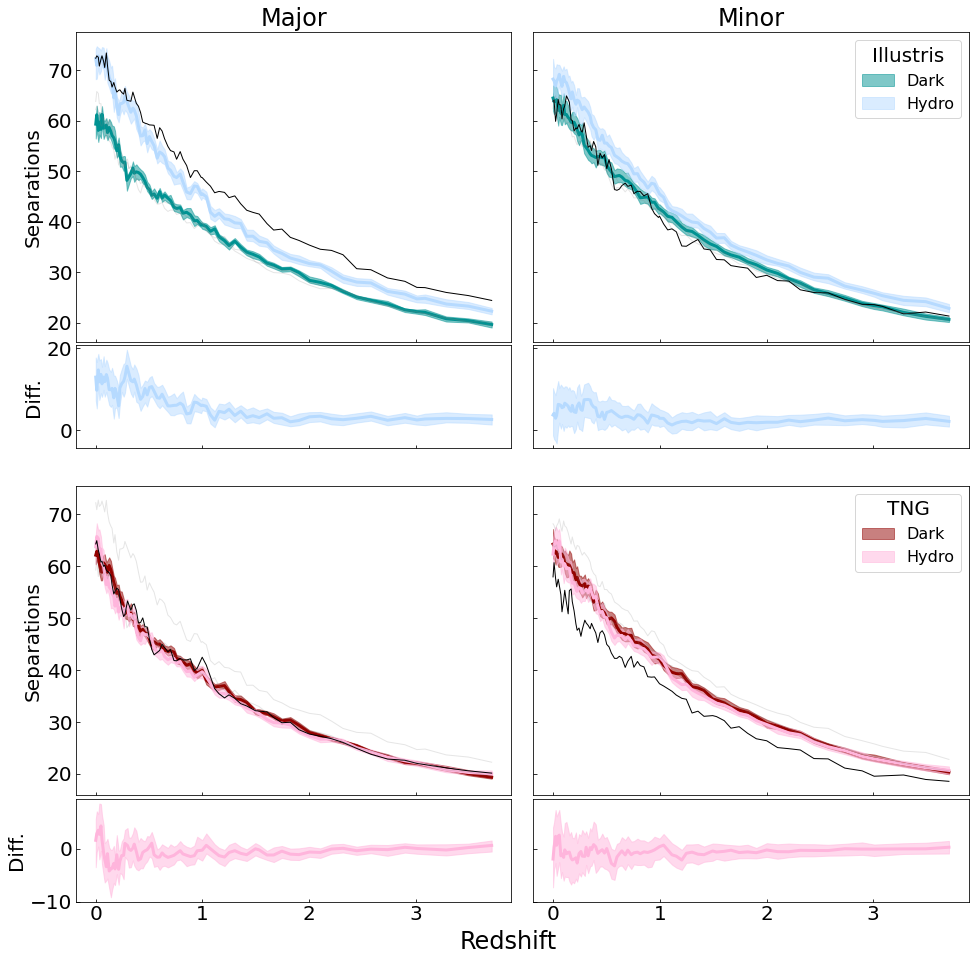

done with virial
starting dwarf with virial_low


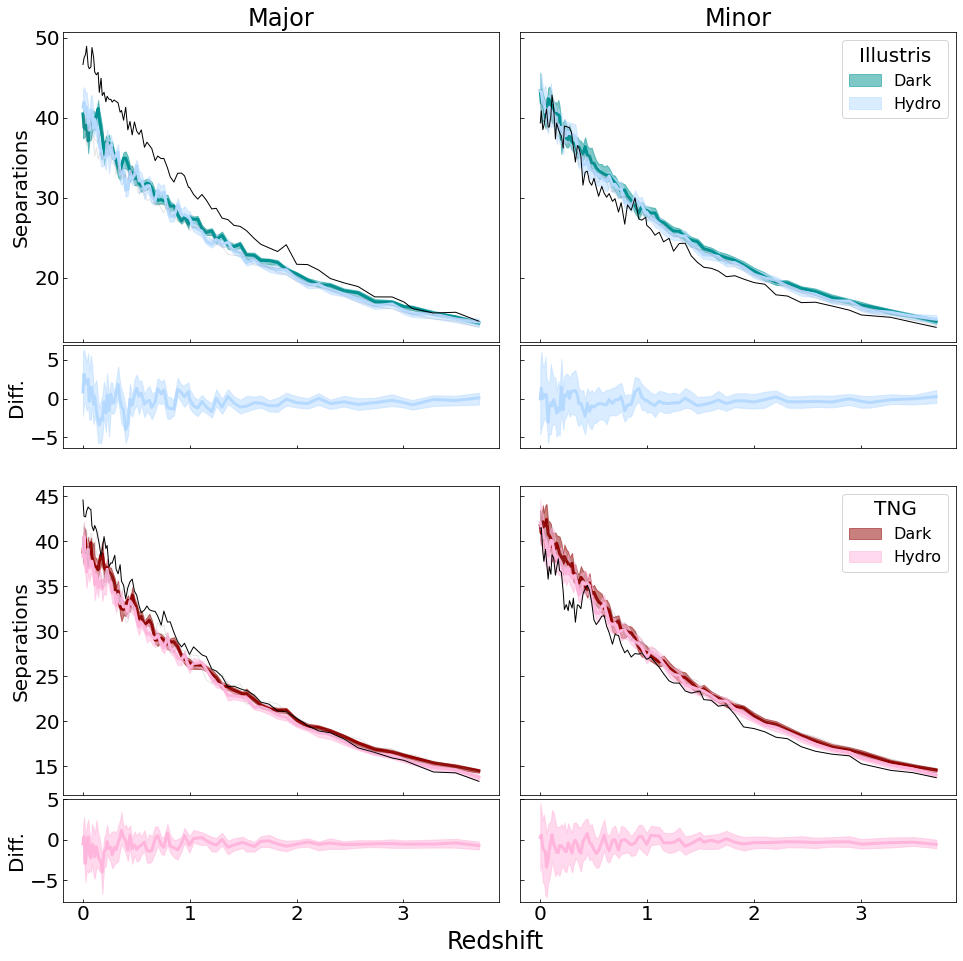

done with virial_low
starting dwarf with virial_high


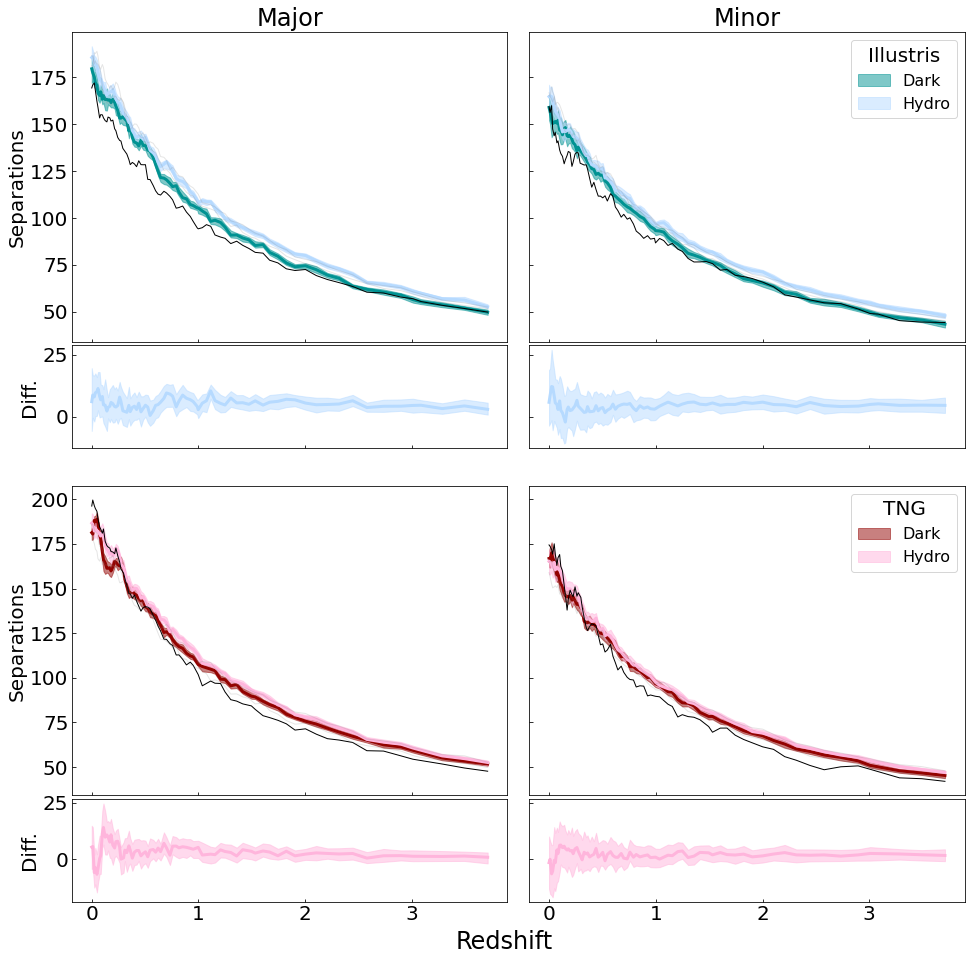

done with virial_high


In [24]:
kwarg_dict_def = {"groupCut": True, 
              "median":False, 
              "errorprint":False, 
              "redshiftcutoff":True}

size = "dwarf"
for septype in ["virial", "virial_low","virial_high"]:#,"default","low", "high",]:
    print(f"starting {size} with {septype}")
    kwarg_dict = {**kwarg_dict_def,
                  "sepmask":septype}
    makeplot_seps(size, **kwarg_dict)
    print(f"done with {septype}")

## Dwarf
### All Pairs

In [9]:
kwarg_dict = {"groupCut": True, 
              "median":True, 
              "errorprint":False, 
              "redshiftcutoff":True,
              "sepmask":"virial_low"}

size = "dwarf"

illd = get_seps("Illustris", "dark", size, **kwarg_dict)
illh = get_seps("Illustris", "hydro", size, **kwarg_dict)
print("done with illustris")

tngd = get_seps("TNG", "dark", size, **kwarg_dict)
tngh = get_seps("TNG", "hydro", size, **kwarg_dict)
print("done with tng")

illsim = get_seps_simstars("Illustris", size, **kwarg_dict)
tngsim = get_seps_simstars("TNG", size, **kwarg_dict)
print("done with stars")


done with illustris
done with tng
done with stars


In [ ]:
## plot of separations of all pairs
fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1],'wspace': 0.05,"hspace":0.02})

axILL = ax[0][0]
axTNG = ax[0][1]
axilldiff = ax[1][0]
axtngdiff = ax[1][1]

########################
# Illustris plot first #
########################
axILL.set(title="Illustris", ylabel="Separations")

axILL.plot(illd['z'],illd['All Median'], color=palette["Illustris dark"], lw=3)
axILL.plot(illh['z'],illh['All Median'], color=palette["Illustris hydro"], lw=3)

axILL.fill_between(illd['z'], np.array(illd['All Quarts'])[:,0], np.array(illd['All Quarts'])[:,1],color=palette["Illustris dark"],alpha=1, label="Illustris dark")
axILL.fill_between(illh['z'], np.array(illh['All Quarts'])[:,0], np.array(illh['All Quarts'])[:,1],color=palette["Illustris hydro"],alpha=1, label="Illustris hydro")

axILL.plot(tngd['z'],tngd['All Median'], color='grey',alpha=0.2, lw=1)
axILL.plot(tngh['z'],tngh["All Median"], color='grey',alpha=0.2, lw=1)

axILL.plot(illsim['z'],illsim['All Median'], color='black', lw=2)


############
# TNG plot #
############
axTNG.set(title="TNG")
axTNG.plot(tngd['z'],tngd['All Median'], color=palette["TNG dark"], lw=3)
axTNG.plot(tngh['z'],tngh['All Median'], color=palette["TNG hydro"], lw=3)

axTNG.fill_between(tngd['z'], np.array(tngd['All Quarts'])[:,0], np.array(tngd['All Quarts'])[:,1],color=palette["TNG dark"],alpha=1, label="TNG dark")
axTNG.fill_between(tngh['z'], np.array(tngh['All Quarts'])[:,0], np.array(tngh['All Quarts'])[:,1],color=palette["TNG hydro"],alpha=1, label="TNG hydro")

axTNG.plot(illd['z'],illd['All Median'], color='grey',alpha=0.2, lw=1)
axTNG.plot(illh['z'],illh['All Median'], color='grey',alpha=0.2, lw=1)

axTNG.plot(tngsim['z'],tngsim['All Median'], color='black', lw=2)


########################
# Illustris difference #
########################
axilldiff.set(ylabel=r"Difference")
axilldiff.plot(illd['z'], np.array(illh['All Median'])-np.array(illd['All Median']), color=palette["Illustris hydro"], lw=3)
# axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['unpaired'])-np.array(illh['unpaired']) )/np.array(illh['unpaired']), color=palette["Illustris hydro"], lw=2, linestyle='dotted')
# axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['paired'])-np.array(illh['paired']) )/np.array(illd['paired']), color=palette["Illustris dark"], lw=2, linestyle='dashed')


########################
# Illustris difference #
########################
axtngdiff.plot(tngd['z'], np.array(tngh['All Median'])-np.array(tngd['All Median']), color=palette["TNG hydro"], lw=3)
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['unpaired'])-np.array(tngh['unpaired']) )/np.array(tngh['unpaired']), color=palette["TNG hydro"], lw=2, linestyle='dotted')
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['paired'])-np.array(tngh['paired']) )/np.array(tngd['paired']), color=palette["TNG dark"], lw=2, linestyle='dashed')
# axtngdiff.set_ylim(0,23)

axILL.legend(loc="upper right",fontsize=16)
axTNG.legend(loc="upper right",fontsize=16)
fig.supxlabel("Redshift")
# plt.savefig(f"../plots/separations/all_{kwarg_dict['sepmask']}_d_100.png",bbox_inches='tight',facecolor="white")
plt.show()


In [ ]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1],'wspace': 0.05,"hspace":0.02})

axd = ax[0]
axh = ax[1]
# axddiff = ax[1][0]
# axhdiff = ax[1][1]

# illd, illh = Illustris['dark'], Illustris['hydro']
# tngd, tngh = TNG['dark'], TNG['hydro']

########################
# Illustris plot first #
########################
axd.set(title="Dark", ylabel="Separations")

axd.plot(illd['z'],illd['All Median'], color=palette["Illustris dark"], lw=3)
axd.plot(tngd['z'],tngd['All Median'], color=palette["TNG dark"], lw=3)

axd.plot(illh['z'],illh['All Median'], color='grey',alpha=0.2, lw=1)
axd.plot(tngh['z'],tngh["All Median"], color='grey',alpha=0.2, lw=1)


############
# TNG plot #
############
axh.set(title="Hydro")
axh.plot(illh['z'],illh['All Median'], color=palette["Illustris hydro"], lw=3)
axh.plot(tngh['z'],tngh['All Median'], color=palette["TNG hydro"], lw=3)

# axTNG.plot(tngd['z'],tngd['unpaired'], color=palette["TNG dark"], lw=2, linestyle="dotted")
# axTNG.plot(tngh['z'],tngh['unpaired'], color=palette["TNG hydro"], lw=2, linestyle="dotted")
# axTNG.plot(tngd['z'],tngd['paired'], color=palette["TNG dark"], lw=2, linestyle="dashed")
# axTNG.plot(tngh['z'],tngh['paired'], color=palette["TNG hydro"], lw=2, linestyle="dashed")

# axTNG.fill_between(tngd['z'], np.array(tngd['quartiles'])[:,0], np.array(tngd['quartiles'])[:,1],color=palette["TNG dark"],alpha=1, label="TNG dark")
# axTNG.fill_between(tngh['z'], np.array(tngh['quartiles'])[:,0], np.array(tngh['quartiles'])[:,1],color=palette["TNG hydro"],alpha=1, label="TNG hydro")

axh.plot(illd['z'],illd['All Median'], color='grey',alpha=0.2, lw=1)
axh.plot(tngd['z'],tngd['All Median'], color='grey',alpha=0.2, lw=1)

# axTNG.plot(simstars['TNG']['z'],simstars['TNG']['prims'], color='black', lw=3)
# axTNG.plot(simstars['TNG']['z'],simstars['TNG']['paired'], color='black',linestyle='dashed', lw=2,alpha=0.8)
# axTNG.plot(simstars['TNG']['z'],simstars['TNG']['unpaired'], color='black',linestyle='dotted', lw=2,alpha=0.8)


########################
# Illustris difference #
########################
# axddiff.set(ylabel=r"$\%$ Difference")
# axddiff.plot(illd['z'], 100*np.abs( np.array(illd['medians'])-np.array(illh['medians']) )/np.array(illh['medians']), color=palette["Illustris hydro"], lw=3)
# axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['unpaired'])-np.array(illh['unpaired']) )/np.array(illh['unpaired']), color=palette["Illustris hydro"], lw=2, linestyle='dotted')
# axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['paired'])-np.array(illh['paired']) )/np.array(illd['paired']), color=palette["Illustris dark"], lw=2, linestyle='dashed')


########################
# Illustris difference #
########################
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['medians'])-np.array(tngh['medians']) )/np.array(tngd['medians']), color=palette["TNG dark"], lw=3)
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['unpaired'])-np.array(tngh['unpaired']) )/np.array(tngh['unpaired']), color=palette["TNG hydro"], lw=2, linestyle='dotted')
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['paired'])-np.array(tngh['paired']) )/np.array(tngd['paired']), color=palette["TNG dark"], lw=2, linestyle='dashed')
# axtngdiff.set_ylim(0,23)

# axILL.legend(loc="upper right",fontsize=16)
# axTNG.legend(loc="upper right",fontsize=16)
fig.supxlabel("Redshift")
# plt.savefig(f"../plots/pairs_plots/counts_dwarfs.png",bbox_inches='tight',facecolor="white")
plt.show()


### Major vs. minor

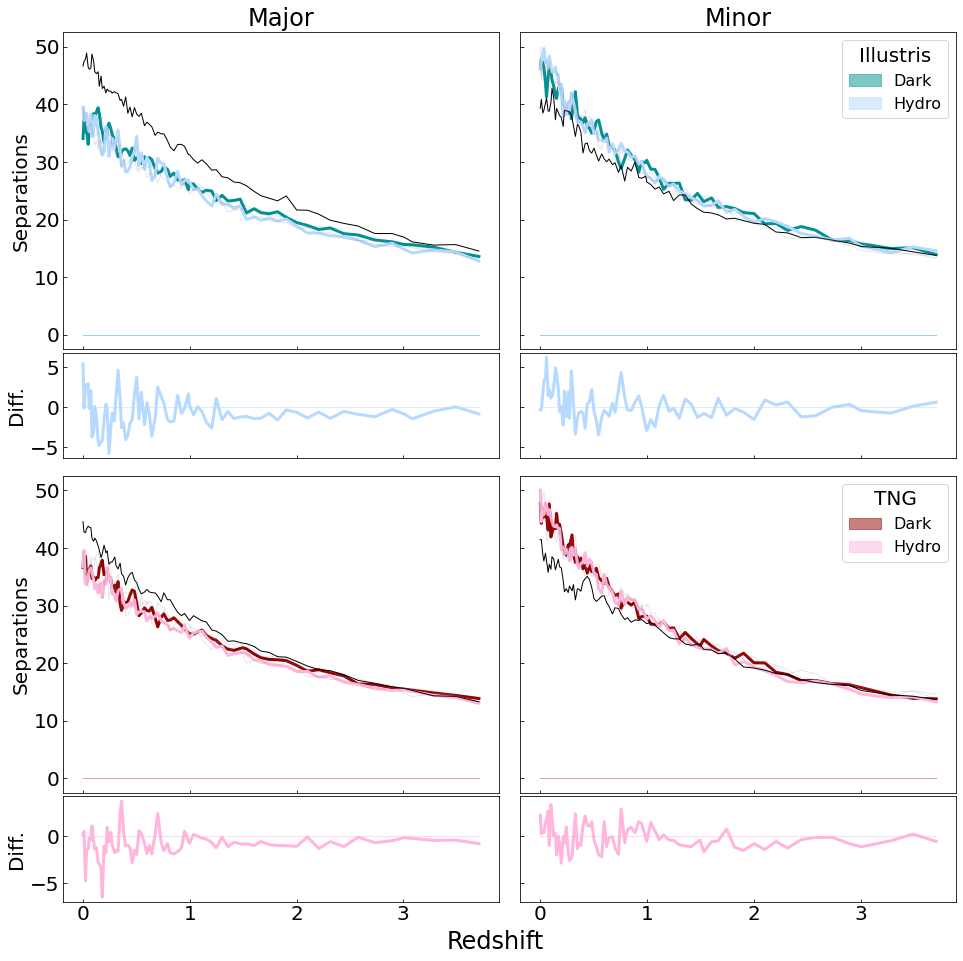

In [10]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.1,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]

axtngmaj = ax[3][0]
axtngmin = ax[3][1]

axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

al = 0.5

###################
# Illustris major #
###################
axillmaj.set(title="Major", ylabel="Separations")
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)
axillmaj.plot(illsim['z'],illsim['Major Median'], color='black', lw=1)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Major Median'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Major Median"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Major Quarts'])[:,0]-np.array(illd['Major Quarts'])[:,1]
highdiff = np.array(illh['Major Quarts'])[:,1]-np.array(illd['Major Quarts'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illh['Major Median'])-np.array(illd['Major Median']) ), color=palette["Illustris hydro"], lw=3)
axillmajdiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.set(title="Minor")
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)
axillmin.plot(illsim['z'],illsim['Minor Median'], color='black', lw=1)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Minor Median'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Minor Quarts'])[:,0]-np.array(illd['Minor Quarts'])[:,1]
highdiff = np.array(illh['Minor Quarts'])[:,1]-np.array(illd['Minor Quarts'])[:,0]
axillmindiff.plot(illd['z'], (np.array(illh['Minor Median'])-np.array(illd['Minor Median']) ), color=palette["Illustris hydro"], lw=3)
axillmindiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Hydro")


#############
# TNG major #
#############
axtngmaj.set(ylabel="Separations")
axtngmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Major Median'], color='black', lw=1)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Major Median'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Major Median"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngh['Major Quarts'])[:,0]-np.array(tngd['Major Quarts'])[:,1]
highdiff = np.array(tngh['Major Quarts'])[:,1]-np.array(tngd['Major Quarts'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngh['Major Median'])-np.array(tngd['Major Median']) ), color=palette["TNG hydro"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(tngsim['z'],tngsim['Minor Median'], color='black', lw=1)

axtngmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Minor Median'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngh['Minor Quarts'])[:,0]-np.array(tngd['Minor Quarts'])[:,1]
highdiff = np.array(tngh['Minor Quarts'])[:,1]-np.array(tngd['Minor Quarts'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngh['Minor Median'])-np.array(tngd['Minor Median']) ), color=palette["TNG hydro"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper right",fontsize=16)
axtngmin.legend(title="TNG",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
# plt.savefig(f"../plots/separations/nogroupcut_majorminor_{kwarg_dict['sepmask']}_d.png",bbox_inches='tight',facecolor="white")
# plt.savefig(f"../plots/separations/majorminor_{kwarg_dict['sepmask']}_d.png",bbox_inches='tight',facecolor="white")
plt.show()


In [ ]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.1,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]

axtngmaj = ax[3][0]
axtngmin = ax[3][1]

axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

al = 0.5

###################
# Illustris major #
###################
axillmaj.set(title="Major", ylabel="Separations")
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)
axillmaj.plot(illsim['z'],illsim['Major Median'], color='black', lw=1)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Major Median'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Major Median"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Major Quarts'])[:,0]-np.array(illd['Major Quarts'])[:,1]
highdiff = np.array(illh['Major Quarts'])[:,1]-np.array(illd['Major Quarts'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illh['Major Median'])-np.array(illd['Major Median']) ), color=palette["Illustris hydro"], lw=3)
axillmajdiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.set(title="Minor")
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)
axillmin.plot(illsim['z'],illsim['Minor Median'], color='black', lw=1)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Minor Median'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Minor Quarts'])[:,0]-np.array(illd['Minor Quarts'])[:,1]
highdiff = np.array(illh['Minor Quarts'])[:,1]-np.array(illd['Minor Quarts'])[:,0]
axillmindiff.plot(illd['z'], (np.array(illh['Minor Median'])-np.array(illd['Minor Median']) ), color=palette["Illustris hydro"], lw=3)
axillmindiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Hydro")


#############
# TNG major #
#############
axtngmaj.set(ylabel="Separations")
axtngmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Major Median'], color='black', lw=1)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Major Median'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Major Median"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngh['Major Quarts'])[:,0]-np.array(tngd['Major Quarts'])[:,1]
highdiff = np.array(tngh['Major Quarts'])[:,1]-np.array(tngd['Major Quarts'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngh['Major Median'])-np.array(tngd['Major Median']) ), color=palette["TNG hydro"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(tngsim['z'],tngsim['Minor Median'], color='black', lw=1)

axtngmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Minor Median'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngh['Minor Quarts'])[:,0]-np.array(tngd['Minor Quarts'])[:,1]
highdiff = np.array(tngh['Minor Quarts'])[:,1]-np.array(tngd['Minor Quarts'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngh['Minor Median'])-np.array(tngd['Minor Median']) ), color=palette["TNG hydro"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper right",fontsize=16)
axtngmin.legend(title="TNG",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/separations/nogroupcut_majorminor_{kwarg_dict['sepmask']}_d.png",bbox_inches='tight',facecolor="white")
# plt.savefig(f"../plots/separations/majorminor_{kwarg_dict['sepmask']}_d.png",bbox_inches='tight',facecolor="white")
plt.show()


## Massive

In [ ]:
kwarg_dict = {"groupCut": True, 
              "median":False, 
              "errorprint":False, 
              "redshiftcutoff":True,
              "sepmask":"low"}

size = "massive"

illd = get_seps("Illustris", "dark", size, **kwarg_dict)
illh = get_seps("Illustris", "hydro", size, **kwarg_dict)

tngd = get_seps("TNG", "dark", size, **kwarg_dict)
tngh = get_seps("TNG", "hydro", size, **kwarg_dict)

illsim = get_seps_simstars("Illustris", size, **kwarg_dict)
tngsim = get_seps_simstars("TNG", size, **kwarg_dict)


### All pairs

In [ ]:
## plot of separations of all pairs
fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1],'wspace': 0.05,"hspace":0.02})

axILL = ax[0][0]
axTNG = ax[0][1]
axilldiff = ax[1][0]
axtngdiff = ax[1][1]

########################
# Illustris plot first #
########################
axILL.set(title="Illustris", ylabel="Separations")

axILL.plot(illd['z'],illd['All Median'], color=palette["Illustris dark"], lw=3)
axILL.plot(illh['z'],illh['All Median'], color=palette["Illustris hydro"], lw=3)

axILL.fill_between(illd['z'], np.array(illd['All Quarts'])[:,0], np.array(illd['All Quarts'])[:,1],color=palette["Illustris dark"],alpha=1, label="Illustris dark")
axILL.fill_between(illh['z'], np.array(illh['All Quarts'])[:,0], np.array(illh['All Quarts'])[:,1],color=palette["Illustris hydro"],alpha=1, label="Illustris hydro")

axILL.plot(tngd['z'],tngd['All Median'], color='grey',alpha=0.2, lw=1)
axILL.plot(tngh['z'],tngh["All Median"], color='grey',alpha=0.2, lw=1)

axILL.plot(illsim['z'],illsim['All Median'], color='black', lw=2)


############
# TNG plot #
############
axTNG.set(title="TNG")
axTNG.plot(tngd['z'],tngd['All Median'], color=palette["TNG dark"], lw=3)
axTNG.plot(tngh['z'],tngh['All Median'], color=palette["TNG hydro"], lw=3)

axTNG.fill_between(tngd['z'], np.array(tngd['All Quarts'])[:,0], np.array(tngd['All Quarts'])[:,1],color=palette["TNG dark"],alpha=1, label="TNG dark")
axTNG.fill_between(tngh['z'], np.array(tngh['All Quarts'])[:,0], np.array(tngh['All Quarts'])[:,1],color=palette["TNG hydro"],alpha=1, label="TNG hydro")

axTNG.plot(illd['z'],illd['All Median'], color='grey',alpha=0.2, lw=1)
axTNG.plot(illh['z'],illh['All Median'], color='grey',alpha=0.2, lw=1)

axTNG.plot(tngsim['z'],tngsim['All Median'], color='black', lw=2)


########################
# Illustris difference #
########################
axilldiff.set(ylabel=r"Difference")
axilldiff.plot(illd['z'], np.array(illh['All Median'])-np.array(illd['All Median']), color=palette["Illustris hydro"], lw=3)
# axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['unpaired'])-np.array(illh['unpaired']) )/np.array(illh['unpaired']), color=palette["Illustris hydro"], lw=2, linestyle='dotted')
# axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['paired'])-np.array(illh['paired']) )/np.array(illd['paired']), color=palette["Illustris dark"], lw=2, linestyle='dashed')


########################
# Illustris difference #
########################
axtngdiff.plot(tngd['z'], np.array(tngh['All Median'])-np.array(tngd['All Median']), color=palette["TNG hydro"], lw=3)
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['unpaired'])-np.array(tngh['unpaired']) )/np.array(tngh['unpaired']), color=palette["TNG hydro"], lw=2, linestyle='dotted')
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['paired'])-np.array(tngh['paired']) )/np.array(tngd['paired']), color=palette["TNG dark"], lw=2, linestyle='dashed')
# axtngdiff.set_ylim(0,23)

axILL.legend(loc="upper right",fontsize=16)
axTNG.legend(loc="upper right",fontsize=16)
fig.supxlabel("Redshift")
plt.savefig(f"../plots/separations/all_{kwarg_dict['sepmask']}_m.png",bbox_inches='tight',facecolor="white")
plt.show()


In [ ]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1],'wspace': 0.05,"hspace":0.02})

axd = ax[0]
axh = ax[1]
# axddiff = ax[1][0]
# axhdiff = ax[1][1]

# illd, illh = Illustris['dark'], Illustris['hydro']
# tngd, tngh = TNG['dark'], TNG['hydro']

########################
# Illustris plot first #
########################
axd.set(title="Dark", ylabel="Separations")

axd.plot(illd['z'],illd['All Median'], color=palette["Illustris dark"], lw=3)
axd.plot(tngd['z'],tngd['All Median'], color=palette["TNG dark"], lw=3)

axd.plot(illh['z'],illh['All Median'], color='grey',alpha=0.2, lw=1)
axd.plot(tngh['z'],tngh["All Median"], color='grey',alpha=0.2, lw=1)


############
# TNG plot #
############
axh.set(title="Hydro")
axh.plot(illh['z'],illh['All Median'], color=palette["Illustris hydro"], lw=3)
axh.plot(tngh['z'],tngh['All Median'], color=palette["TNG hydro"], lw=3)

# axTNG.plot(tngd['z'],tngd['unpaired'], color=palette["TNG dark"], lw=2, linestyle="dotted")
# axTNG.plot(tngh['z'],tngh['unpaired'], color=palette["TNG hydro"], lw=2, linestyle="dotted")
# axTNG.plot(tngd['z'],tngd['paired'], color=palette["TNG dark"], lw=2, linestyle="dashed")
# axTNG.plot(tngh['z'],tngh['paired'], color=palette["TNG hydro"], lw=2, linestyle="dashed")

# axTNG.fill_between(tngd['z'], np.array(tngd['quartiles'])[:,0], np.array(tngd['quartiles'])[:,1],color=palette["TNG dark"],alpha=1, label="TNG dark")
# axTNG.fill_between(tngh['z'], np.array(tngh['quartiles'])[:,0], np.array(tngh['quartiles'])[:,1],color=palette["TNG hydro"],alpha=1, label="TNG hydro")

axh.plot(illd['z'],illd['All Median'], color='grey',alpha=0.2, lw=1)
axh.plot(tngd['z'],tngd['All Median'], color='grey',alpha=0.2, lw=1)

# axTNG.plot(simstars['TNG']['z'],simstars['TNG']['prims'], color='black', lw=3)
# axTNG.plot(simstars['TNG']['z'],simstars['TNG']['paired'], color='black',linestyle='dashed', lw=2,alpha=0.8)
# axTNG.plot(simstars['TNG']['z'],simstars['TNG']['unpaired'], color='black',linestyle='dotted', lw=2,alpha=0.8)


########################
# Illustris difference #
########################
# axddiff.set(ylabel=r"$\%$ Difference")
# axddiff.plot(illd['z'], 100*np.abs( np.array(illd['medians'])-np.array(illh['medians']) )/np.array(illh['medians']), color=palette["Illustris hydro"], lw=3)
# axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['unpaired'])-np.array(illh['unpaired']) )/np.array(illh['unpaired']), color=palette["Illustris hydro"], lw=2, linestyle='dotted')
# axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['paired'])-np.array(illh['paired']) )/np.array(illd['paired']), color=palette["Illustris dark"], lw=2, linestyle='dashed')


########################
# Illustris difference #
########################
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['medians'])-np.array(tngh['medians']) )/np.array(tngd['medians']), color=palette["TNG dark"], lw=3)
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['unpaired'])-np.array(tngh['unpaired']) )/np.array(tngh['unpaired']), color=palette["TNG hydro"], lw=2, linestyle='dotted')
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['paired'])-np.array(tngh['paired']) )/np.array(tngd['paired']), color=palette["TNG dark"], lw=2, linestyle='dashed')
# axtngdiff.set_ylim(0,23)

# axILL.legend(loc="upper right",fontsize=16)
# axTNG.legend(loc="upper right",fontsize=16)
fig.supxlabel("Redshift")
# plt.savefig(f"../plots/pairs_plots/counts_dwarfs.png",bbox_inches='tight',facecolor="white")
plt.show()


### Major vs. minor

In [ ]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.3,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]

axtngmaj = ax[3][0]
axtngmin = ax[3][1]

axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

al = 0.5

###################
# Illustris major #
###################
axillmaj.set(title="Major", ylabel="Separations")
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)
axillmaj.plot(illsim['z'],illsim['Major Median'], color='black', lw=1)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Major Median'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Major Median"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Major Quarts'])[:,0]-np.array(illd['Major Quarts'])[:,1]
highdiff = np.array(illh['Major Quarts'])[:,1]-np.array(illd['Major Quarts'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illh['Major Median'])-np.array(illd['Major Median']) ), color=palette["Illustris hydro"], lw=3)
axillmajdiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.set(title="Minor")
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)
axillmin.plot(illsim['z'],illsim['Minor Median'], color='black', lw=1)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Minor Median'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Minor Quarts'])[:,0]-np.array(illd['Minor Quarts'])[:,1]
highdiff = np.array(illh['Minor Quarts'])[:,1]-np.array(illd['Minor Quarts'])[:,0]
axillmindiff.plot(illd['z'], (np.array(illh['Minor Median'])-np.array(illd['Minor Median']) ), color=palette["Illustris hydro"], lw=3)
axillmindiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Hydro")


#############
# TNG major #
#############
axtngmaj.set(ylabel="Separations")
axtngmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Major Median'], color='black', lw=1)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Major Median'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Major Median"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngh['Major Quarts'])[:,0]-np.array(tngd['Major Quarts'])[:,1]
highdiff = np.array(tngh['Major Quarts'])[:,1]-np.array(tngd['Major Quarts'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngh['Major Median'])-np.array(tngd['Major Median']) ), color=palette["TNG hydro"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(tngsim['z'],tngsim['Minor Median'], color='black', lw=1)

axtngmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Minor Median'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngh['Minor Quarts'])[:,0]-np.array(tngd['Minor Quarts'])[:,1]
highdiff = np.array(tngh['Minor Quarts'])[:,1]-np.array(tngd['Minor Quarts'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngh['Minor Median'])-np.array(tngd['Minor Median']) ), color=palette["TNG hydro"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper right",fontsize=16)
axtngmin.legend(title="TNG",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/separations/majorminor_{kwarg_dict['sepmask']}_m.png",bbox_inches='tight',facecolor="white")
plt.show()


# Separation distributions

In [10]:
# make functions to get data at the requested snapshot
def get_primmask(primstells, size):
    if size == "dwarf":
        mask = (primstells > 0.01) & (primstells < 0.5)
    elif size == "massive":
        mask = (primstells > 0.5) & (primstells < 10)
    return mask

def get_groupmask(groupmass, size):
    if size == "dwarf":
        mask = (groupmass > 8) & (groupmass < 50)
    elif size == "massive":
        mask = (groupmass > 100) & (groupmass < 650)
    return mask
        
def get_sepmask(seps, key="default", **kwargs):
    """Note: key can be
    'high' -- sep > 100
    'low'  -- 10 < sep < 80
    'default' -- sep > 10
    'virial_low' -- sep < 1/2 Rvir
    'virial_high' -- sep > 1/2 Rvir
    'spec' -- specify the lower and upper bound with kwargs
    ---
    kwargs: **{"min": lower bound, "max": upper bound, "groupRadius":Group radius array}
    """
    seps = np.array(seps)
    minn = kwargs.pop("min",10)
    maxx = kwargs.pop("max",1000)
    rads = kwargs.pop("groupRadius",100*np.ones(len(seps)))
    
    if key == "high":
        mask = seps > 100
    elif key == "low":
        mask = (seps > 10) & (seps < 80)
    elif key == "default":
        mask = seps > 10
    elif key == "spec":
        mask = (seps > minn) & (seps < maxx)
    elif key =="virial_low":
        mask = (seps > 10) & (seps < 0.5*rads)
    elif key =="virial_high":
        mask = (seps > 0.5*rads)
    return mask

In [11]:
# functions to get the primaries and secondaries based on AM mass
def get_majmin(sim, phys, size, z, key="Sub1 Mass", groupCut=False, median=False, **kwargs):
    zloc = np.where( zs['z'] == z)[0]
    minn = kwargs.pop("min",10)
    maxx = kwargs.pop("max",1000)
    sepmask = kwargs.pop("sepmask","default")
    
    if sim == "Illustris":
        snapshot = zs['zill'][zloc][0]
    elif sim == "TNG":
        snapshot = zs['ztng'][zloc][0]      
        
    pair_path = f"{sim}_{snapshot}_100.hdf5"
    pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
    
    pairs = pair_data["pairs"][phys]

    pri_stell = np.array(pairs["Sub1 Stellar Mass"])
    sec_stell = np.array(pairs["Sub2 Stellar Mass"])
    grouprads = np.array(pairs["Group Radius"])
    seps = np.array(pairs["Separation"]) 

    # masks            
    pair_pri = get_primmask(pri_stell, size)
    pair_group = get_groupmask(np.array(pairs["Group Mass"]), size)
    pair_medreal = np.array( pairs['Realization'] ) == -1
    pair_sepcut = get_sepmask(seps, key=sepmask,**{"min":minn,"max":maxx, "groupRadius":grouprads})

    majors = (sec_stell/pri_stell > 1/4)
    minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

    pair_mask = pair_pri & pair_sepcut
        
    major_mask = pair_mask & majors
    minor_mask = pair_mask & minors
    
    if groupCut:
        major_mask = major_mask & pair_group
        minor_mask = minor_mask & pair_group
        
    if median: 
        major_mask = major_mask & pair_medreal
        minor_mask = minor_mask & pair_medreal
    
    major_key = np.array(pairs[key])[major_mask]
    minor_key = np.array(pairs[key])[minor_mask]
    
    pair_dict = {"majors":major_key, "minors":minor_key}
        
    return pair_dict

def get_majmin_simstell(sim, size, z, key="Sub1 Mass", groupCut=False, **kwargs):
    zloc = np.where( zs['z'] == z)[0]
    minn = kwargs.pop("min",10)
    maxx = kwargs.pop("max",1000)
    
    if sim == "Illustris":
        snapshot = zs['zill'][zloc][0]
    elif sim == "TNG":
        snapshot = zs['ztng'][zloc][0]      
        
    pair_path = f"{sim}_{snapshot}_simstars.hdf5"
    pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
    
    pairs = pair_data["paired"]["hydro"]

    pri_stell = np.array(pairs["Sub1 Stellar Mass"])
    sec_stell = np.array(pairs["Sub2 Stellar Mass"])
    grouprads = np.array(pairs["Group Radius"])
    seps = np.array(pairs["Separation"]) 

    # masks            
    pair_pri = get_primmask(pri_stell, size)
    pair_group = get_groupmask(np.array(pairs["Group Mass"]), size)
    pair_sepcut = get_sepmask(seps, key="default",**{"min":minn,"max":maxx, "groupRadius":grouprads})

    majors = (sec_stell/pri_stell > 1/4)
    minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

    pair_mask = pair_pri & pair_sepcut
        
    major_mask = pair_mask & majors
    minor_mask = pair_mask & minors
    
    if groupCut:
        major_mask = major_mask & pair_group
        minor_mask = minor_mask & pair_group
            
    major_key = np.array(pairs[key])[major_mask]
    minor_key = np.array(pairs[key])[minor_mask]
    
    pair_dict = {"majors":major_key, "minors":minor_key}
        
    return pair_dict


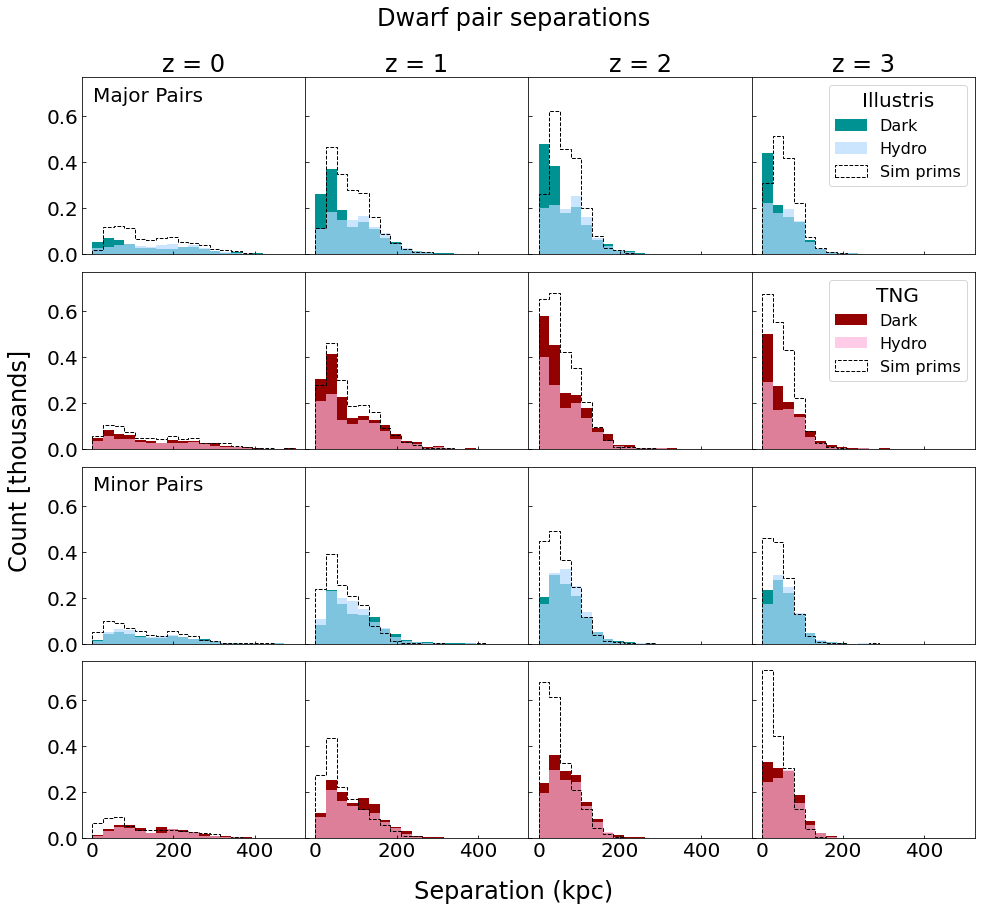

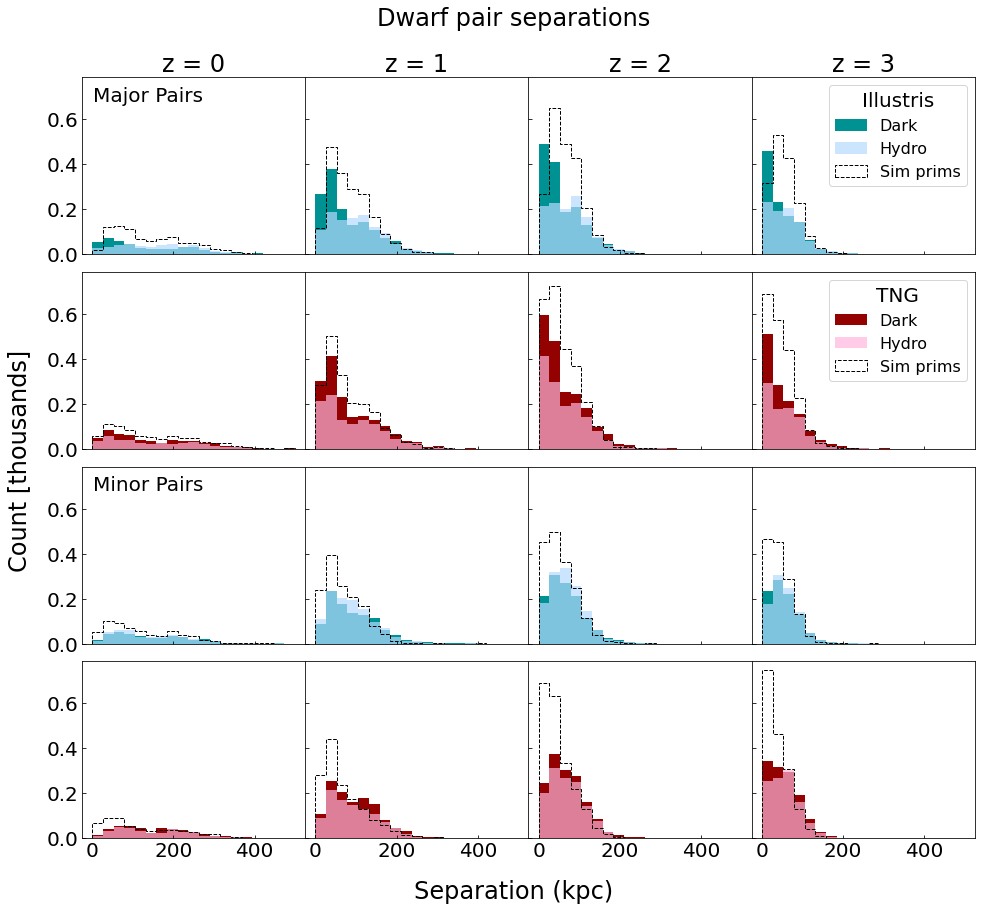

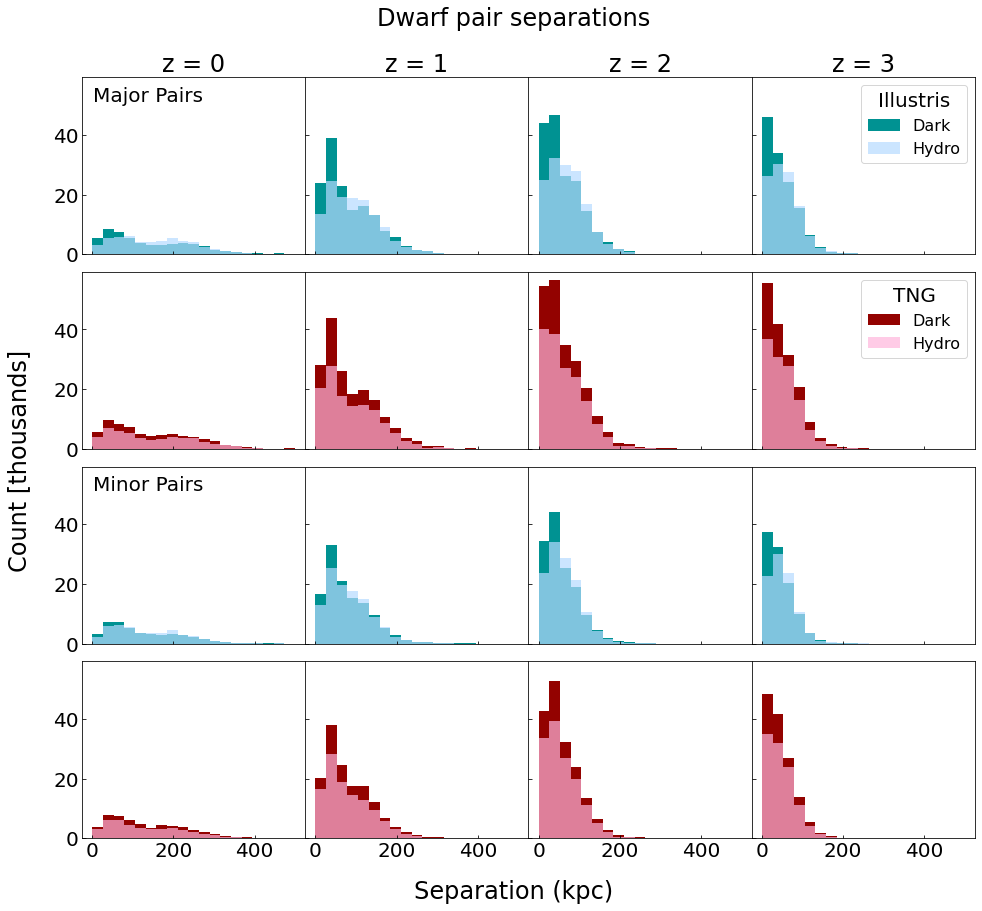

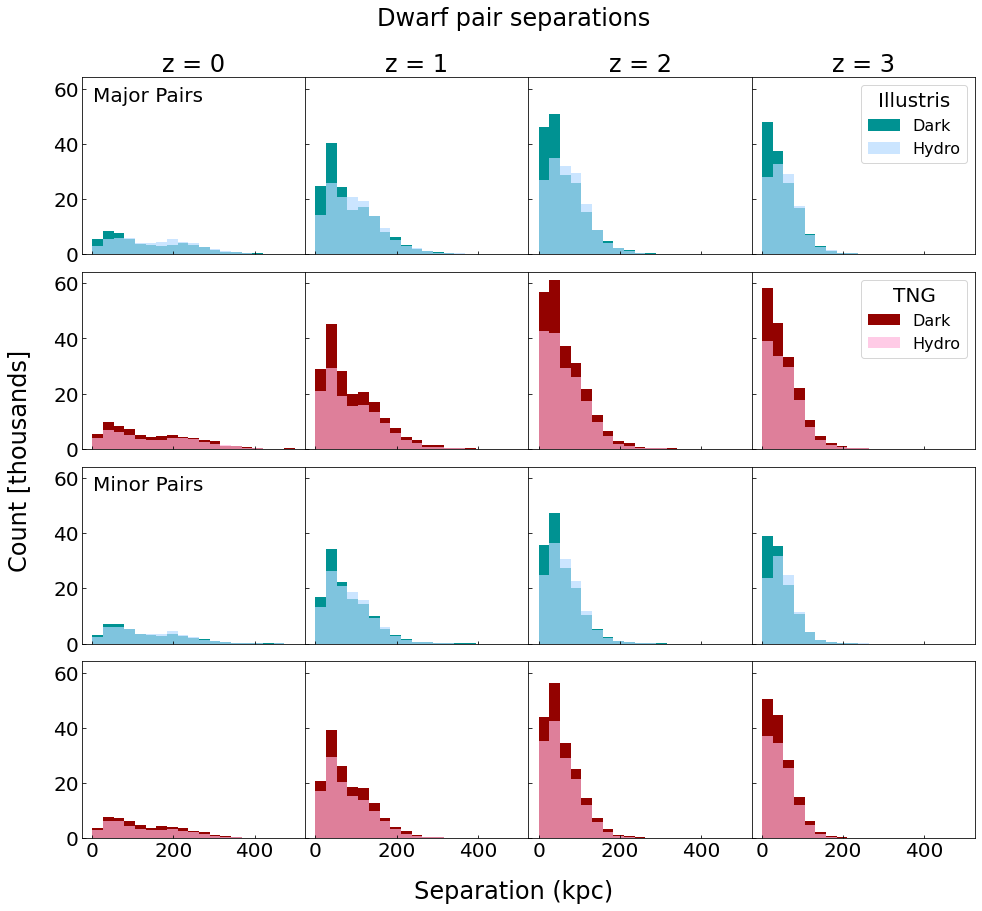

In [21]:
# Dwarf - separation distribution
for median_it in [True,False]:
    for group_it in [True,False]:
        fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
        plt.subplots_adjust(wspace=0,hspace=0.1)
        bins = np.linspace(0,500,20)
        weight = 1000
        key = "Separation"
        size = "dwarf"
        kwargs_dict = {"median":median_it,
                       "groupCut": group_it,
                       "sepmask":"default"}

        if size == "dwarf":
            sizelabel = "d"
        elif size == "massive":
            sizelabel = "m"

        if kwargs_dict["median"]:
            medianlabel = "median"
        else:
            medianlabel = "allreals"

        if kwargs_dict["groupCut"]:
            grouplabel = "groupcut"
        else:
            grouplabel = "nogroupcut"

        for i in range(4):
            ax[0][i].set_title(f"z = {i}")

            illd = get_majmin("Illustris","dark", size, i, key, **kwargs_dict)
            illh = get_majmin("Illustris","hydro", size, i, key, **kwargs_dict)
            tngd = get_majmin("TNG","dark", size, i, key, **kwargs_dict)
            tngh = get_majmin("TNG","hydro", size, i, key, **kwargs_dict)

            illsim = get_majmin_simstell("Illustris", size, i, key, **kwargs_dict)
            tngsim = get_majmin_simstell("TNG", size, i, key, **kwargs_dict)

            # Illustris Major pairs
            ax[0][i].hist(illd['majors'],weights=np.ones(len(illd['majors']))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
            ax[0][i].hist(illh['majors'],weights=np.ones(len(illh['majors']))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')

            # TNG Major pairs
            ax[1][i].hist(tngd['majors'],weights=np.ones(len(tngd['majors']))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
            ax[1][i].hist(tngh['majors'],weights=np.ones(len(tngh['majors']))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')

            # Illustris Minor pairs
            ax[2][i].hist(illd['minors'],weights=np.ones(len(illd['minors']))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
            ax[2][i].hist(illh['minors'],weights=np.ones(len(illh['minors']))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')

            # TNG Minor pairs
            ax[3][i].hist(tngd['minors'],weights=np.ones(len(tngd['minors']))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
            ax[3][i].hist(tngh['minors'],weights=np.ones(len(tngh['minors']))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')


            if kwargs_dict['median']:
                ax[0][i].hist(illsim['majors'],weights=np.ones(len(illsim['majors']))/weight,histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
                ax[1][i].hist(tngsim['majors'],weights=np.ones(len(tngsim['majors']))/weight,histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
                ax[2][i].hist(illsim['minors'],weights=np.ones(len(illsim['minors']))/weight,histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
                ax[3][i].hist(tngsim['minors'],weights=np.ones(len(tngsim['minors']))/weight,histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

        ax[0][3].legend(title="Illustris",fontsize=16)
        ax[1][3].legend(title="TNG",fontsize=16)
        xlims, ylims = ax[0][0].get_xlim(), ax[0][0].get_ylim()
        xwidth, ywidth = np.diff(xlims), np.diff(ylims)


        ax[0][0].text(xlims[0]+0.05*xwidth,ylims[1]-0.05*ywidth,"Major Pairs",va='top')
        ax[2][0].text(xlims[0]+0.05*xwidth,ylims[1]-0.05*ywidth,"Minor Pairs",va='top')

        fig.suptitle("Dwarf pair separations",y=0.95)
        fig.supxlabel(r"Separation (kpc)",y=0.06)
        fig.supylabel("Count [thousands]",x=0.060)

        plt.savefig(f"../plots/separations/sepdist_{medianlabel}_{grouplabel}_{sizelabel}.png",bbox_inches='tight',facecolor="white")
        plt.show()

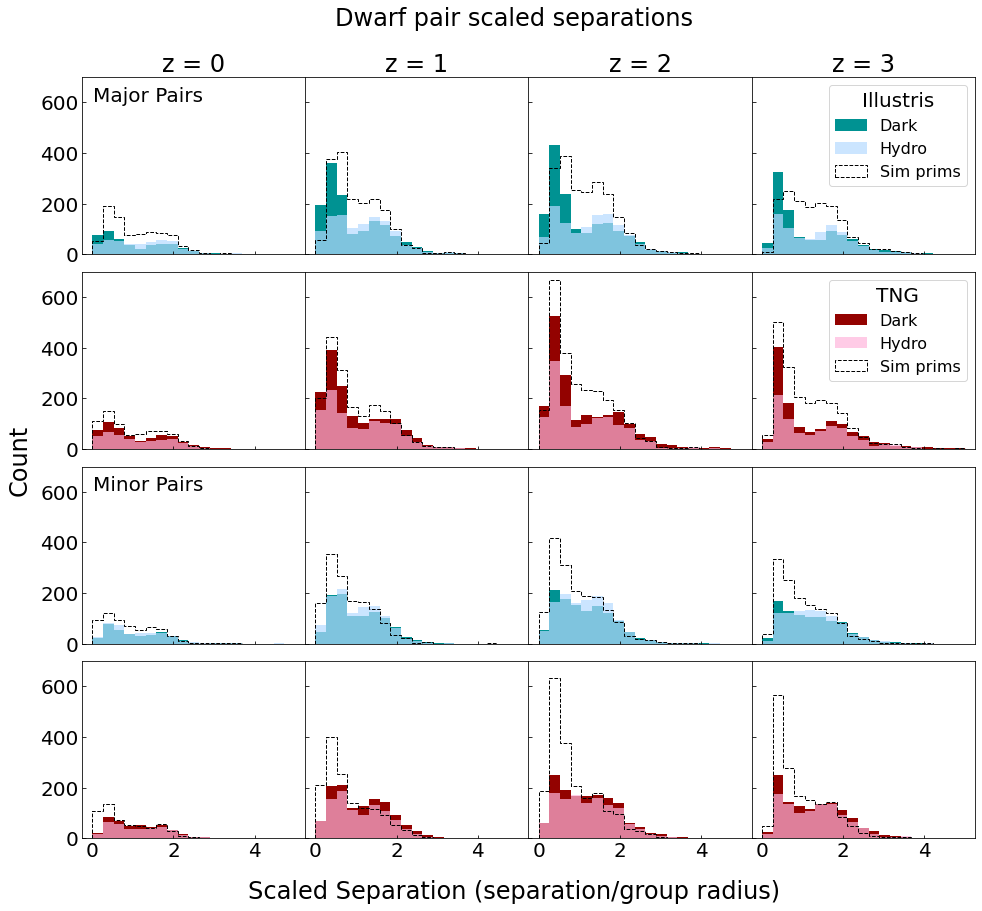

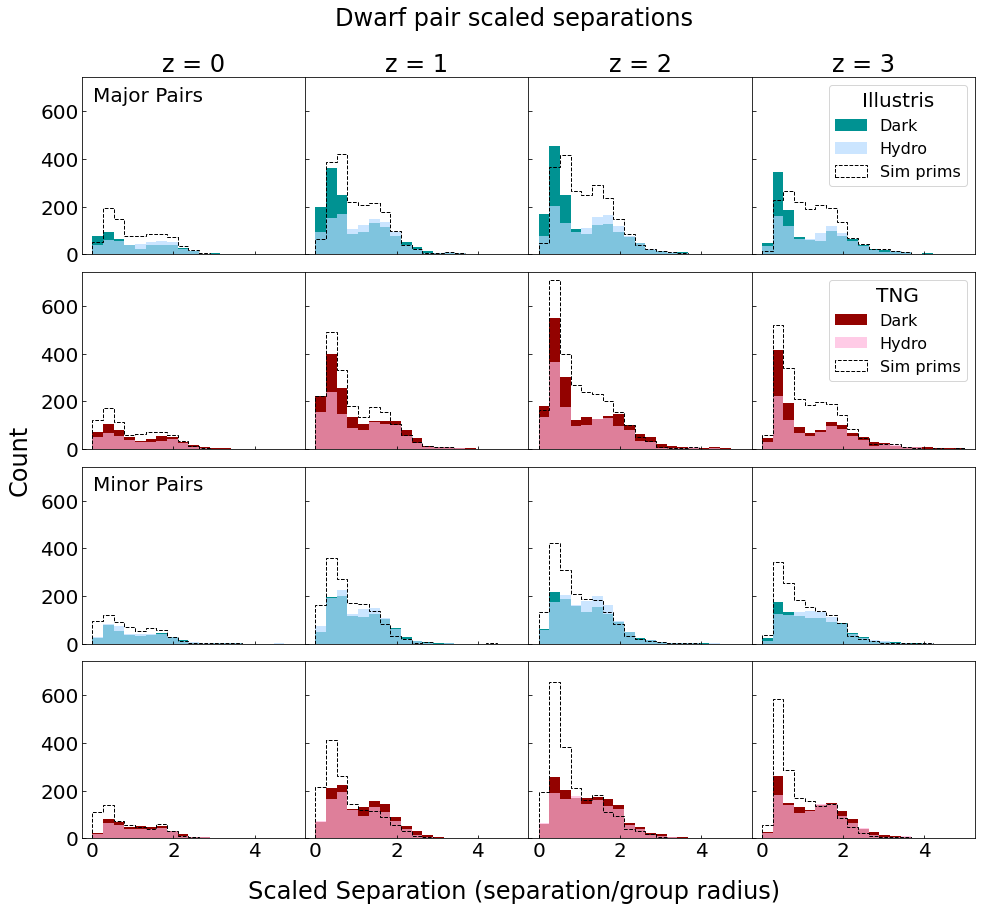

In [25]:
# Dwarf - scaled separation
for median_it in [True,False]:
    if median_it == False:
        continue
        
    for group_it in [True,False]:

        fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
        plt.subplots_adjust(wspace=0,hspace=0.1)
        bins = np.linspace(0,5,20)
        weight = 1
        key = "Separation"
        size = "dwarf"
        kwargs_dict = {"median":median_it,
                       "groupCut": group_it,
                       "sepmask":"default"}

        if size == "dwarf":
            sizelabel = "d"
        elif size == "massive":
            sizelabel = "m"

        if kwargs_dict["median"]:
            medianlabel = "median"
        else:
            medianlabel = "allreals"

        if kwargs_dict["groupCut"]:
            grouplabel = "groupcut"
        else:
            grouplabel = "nogroupcut"

        for i in range(4):
            ax[0][i].set_title(f"z = {i}")

            illdsep = get_majmin("Illustris","dark", size, i, key, **kwargs_dict)
            illdrad = get_majmin("Illustris","dark", size, i, "Group Radius", **kwargs_dict)
            illhsep = get_majmin("Illustris","hydro", size, i, key, **kwargs_dict)
            illhrad = get_majmin("Illustris","hydro", size, i, "Group Radius", **kwargs_dict)
            tngdsep = get_majmin("TNG","dark", size, i, key, **kwargs_dict)
            tngdrad = get_majmin("TNG","dark", size, i, "Group Radius", **kwargs_dict)
            tnghsep = get_majmin("TNG","hydro", size, i, key, **kwargs_dict)
            tnghrad = get_majmin("TNG","hydro", size, i, "Group Radius", **kwargs_dict)
            

            illsimsep = get_majmin_simstell("Illustris", size, i, key, **kwargs_dict)
            illsimrad = get_majmin_simstell("Illustris", size, i, "Group Radius", **kwargs_dict)
            tngsimsep = get_majmin_simstell("TNG", size, i, key, **kwargs_dict)
            tngsimrad = get_majmin_simstell("TNG", size, i, "Group Radius", **kwargs_dict)

            # Illustris Major pairs
            ax[0][i].hist(illdsep['majors']/illdrad['majors'],weights=np.ones(len(illdsep['majors']))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
            ax[0][i].hist(illhsep['majors']/illhrad['majors'],weights=np.ones(len(illhsep['majors']))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')

            # TNG Major pairs
            ax[1][i].hist(tngdsep['majors']/tngdrad['majors'],weights=np.ones(len(tngdsep['majors']))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
            ax[1][i].hist(tnghsep['majors']/tnghrad['majors'],weights=np.ones(len(tnghsep['majors']))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')

            # Illustris Minor pairs
            ax[2][i].hist(illdsep['minors']/illdrad['minors'],weights=np.ones(len(illdsep['minors']))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
            ax[2][i].hist(illhsep['minors']/illhrad['minors'],weights=np.ones(len(illhsep['minors']))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')

            # TNG Minor pairs
            ax[3][i].hist(tngdsep['minors']/tngdrad['minors'],weights=np.ones(len(tngdsep['minors']))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
            ax[3][i].hist(tnghsep['minors']/tnghrad['minors'],weights=np.ones(len(tnghsep['minors']))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')


            if kwargs_dict['median']:
                ax[0][i].hist(illsimsep['majors']/illsimrad['majors'],weights=np.ones(len(illsimsep['majors']))/weight,histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
                ax[1][i].hist(tngsimsep['majors']/tngsimrad['majors'],weights=np.ones(len(tngsimsep['majors']))/weight,histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
                ax[2][i].hist(illsimsep['minors']/illsimrad['minors'],weights=np.ones(len(illsimsep['minors']))/weight,histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
                ax[3][i].hist(tngsimsep['minors']/tngsimrad['minors'],weights=np.ones(len(tngsimsep['minors']))/weight,histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

        ax[0][3].legend(title="Illustris",fontsize=16)
        ax[1][3].legend(title="TNG",fontsize=16)
        xlims, ylims = ax[0][0].get_xlim(), ax[0][0].get_ylim()
        xwidth, ywidth = np.diff(xlims), np.diff(ylims)


        ax[0][0].text(xlims[0]+0.05*xwidth,ylims[1]-0.05*ywidth,"Major Pairs",va='top')
        ax[2][0].text(xlims[0]+0.05*xwidth,ylims[1]-0.05*ywidth,"Minor Pairs",va='top')

        fig.suptitle("Dwarf pair scaled separations",y=0.95)
        fig.supxlabel(r"Scaled Separation (separation/group radius)",y=0.06)
        fig.supylabel("Count",x=0.060)

        plt.savefig(f"../plots/separations/scaledsepdist_{medianlabel}_{grouplabel}_{sizelabel}.png",bbox_inches='tight',facecolor="white")
        plt.show()

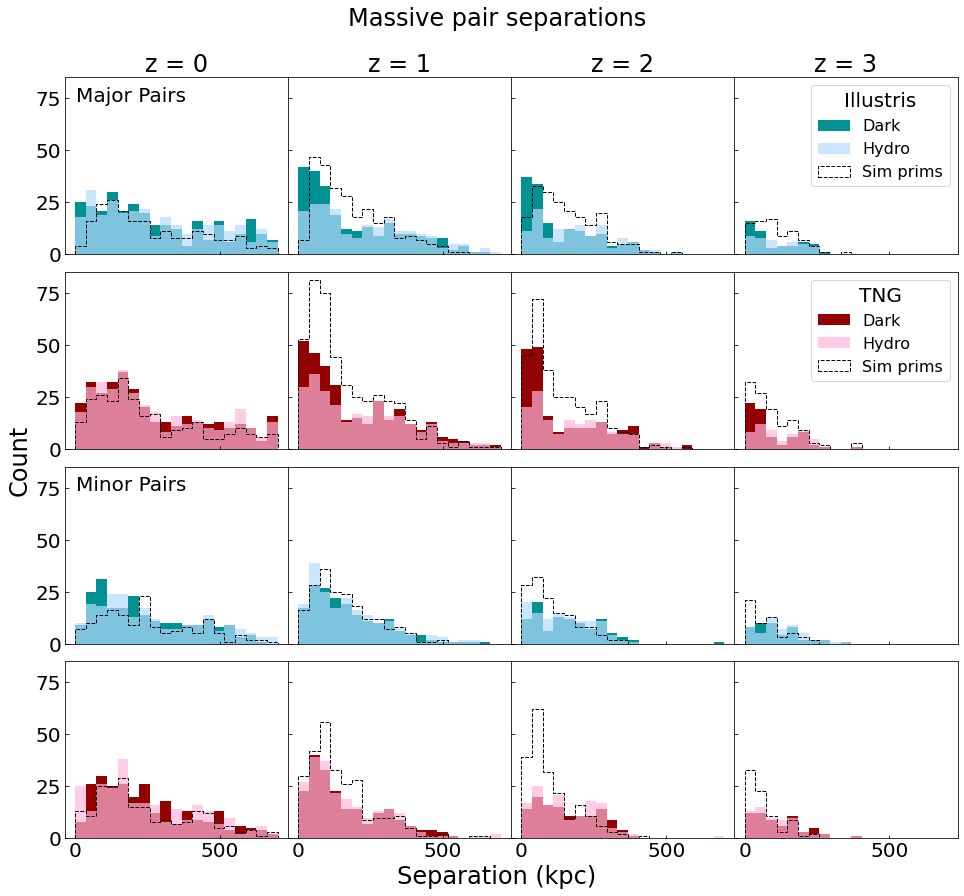

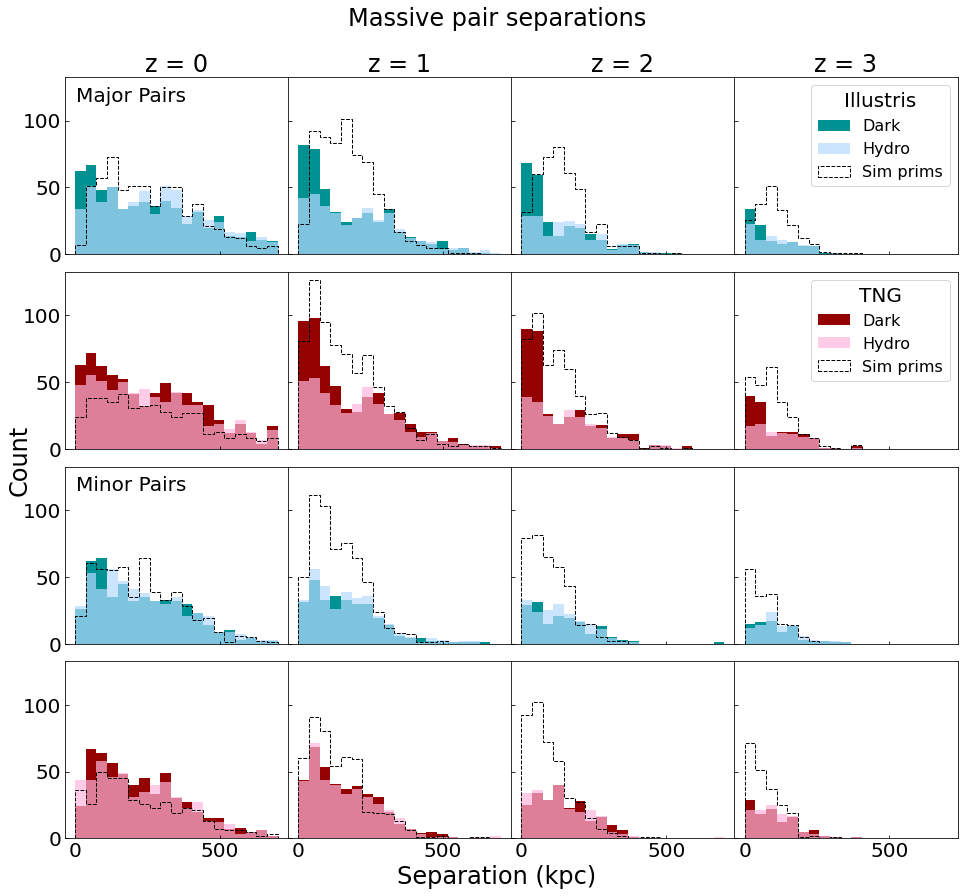

In [24]:
# Massive - separation distribution
for median_it in [True,False]:
    if median_it == False:
        continue
    for group_it in [True,False]:
        fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
        plt.subplots_adjust(wspace=0,hspace=0.1)
        bins = np.linspace(0,700,20)
        weight = 1
        key = "Separation"
        size = "massive"
        kwargs_dict = {"median":median_it,
                       "groupCut": group_it,
                       "sepmask":"default"}

        if size == "dwarf":
            sizelabel = "d"
        elif size == "massive":
            sizelabel = "m"

        if kwargs_dict["median"]:
            medianlabel = "median"
        else:
            medianlabel = "allreals"

        if kwargs_dict["groupCut"]:
            grouplabel = "groupcut"
        else:
            grouplabel = "nogroupcut"

        for i in range(4):
            ax[0][i].set_title(f"z = {i}")

            illd = get_majmin("Illustris","dark", size, i, key, **kwargs_dict)
            illh = get_majmin("Illustris","hydro", size, i, key, **kwargs_dict)
            tngd = get_majmin("TNG","dark", size, i, key, **kwargs_dict)
            tngh = get_majmin("TNG","hydro", size, i, key, **kwargs_dict)

            illsim = get_majmin_simstell("Illustris", size, i, key, **kwargs_dict)
            tngsim = get_majmin_simstell("TNG", size, i, key, **kwargs_dict)

            # Illustris Major pairs
            ax[0][i].hist(illd['majors'],weights=np.ones(len(illd['majors']))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
            ax[0][i].hist(illh['majors'],weights=np.ones(len(illh['majors']))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')

            # TNG Major pairs
            ax[1][i].hist(tngd['majors'],weights=np.ones(len(tngd['majors']))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
            ax[1][i].hist(tngh['majors'],weights=np.ones(len(tngh['majors']))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')

            # Illustris Minor pairs
            ax[2][i].hist(illd['minors'],weights=np.ones(len(illd['minors']))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
            ax[2][i].hist(illh['minors'],weights=np.ones(len(illh['minors']))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')

            # TNG Minor pairs
            ax[3][i].hist(tngd['minors'],weights=np.ones(len(tngd['minors']))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
            ax[3][i].hist(tngh['minors'],weights=np.ones(len(tngh['minors']))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')


            if kwargs_dict['median']:
                ax[0][i].hist(illsim['majors'],weights=np.ones(len(illsim['majors']))/weight,histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
                ax[1][i].hist(tngsim['majors'],weights=np.ones(len(tngsim['majors']))/weight,histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
                ax[2][i].hist(illsim['minors'],weights=np.ones(len(illsim['minors']))/weight,histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
                ax[3][i].hist(tngsim['minors'],weights=np.ones(len(tngsim['minors']))/weight,histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

        ax[0][3].legend(title="Illustris",fontsize=16)
        ax[1][3].legend(title="TNG",fontsize=16)
        xlims, ylims = ax[0][0].get_xlim(), ax[0][0].get_ylim()
        xwidth, ywidth = np.diff(xlims), np.diff(ylims)


        ax[0][0].text(xlims[0]+0.05*xwidth,ylims[1]-0.05*ywidth,"Major Pairs",va='top')
        ax[2][0].text(xlims[0]+0.05*xwidth,ylims[1]-0.05*ywidth,"Minor Pairs",va='top')

        fig.suptitle("Massive pair separations",y=0.95)
        fig.supxlabel(r"Separation (kpc)",y=0.075)
        fig.supylabel("Count",x=0.075)

        plt.savefig(f"../plots/separations/sepdist_{medianlabel}_{grouplabel}_{sizelabel}.png",bbox_inches='tight',facecolor="white")
        plt.show()

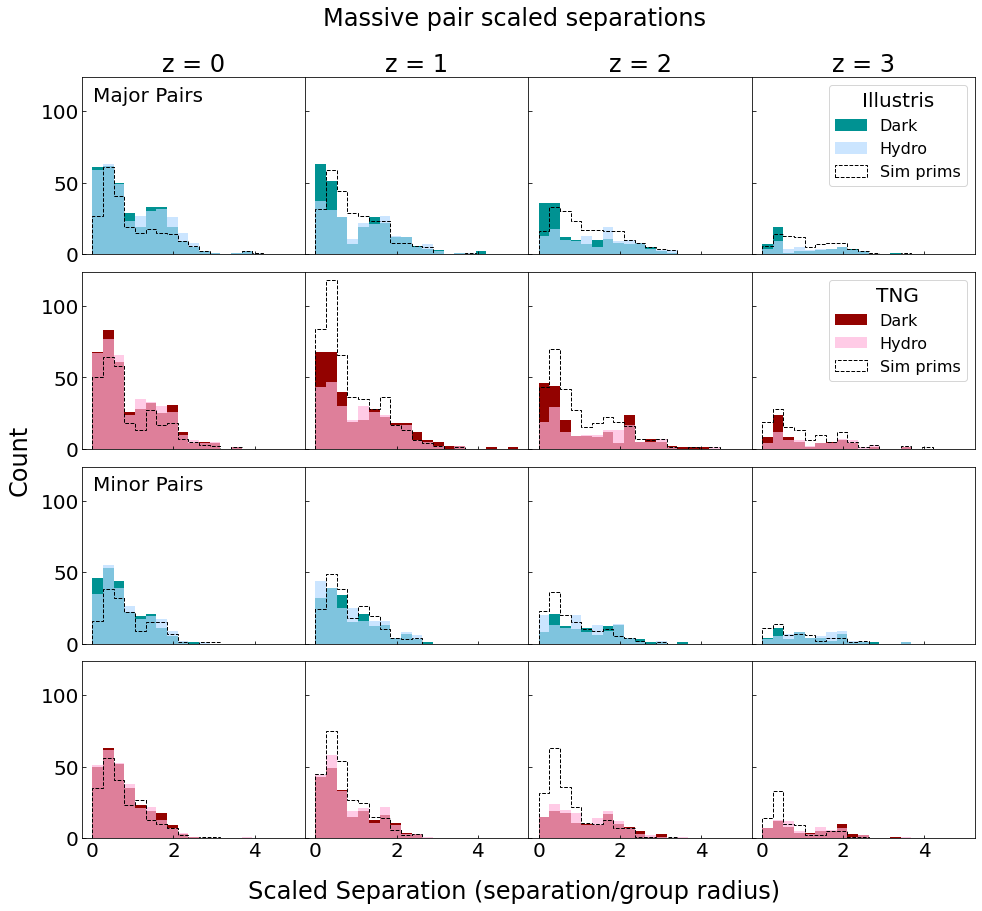

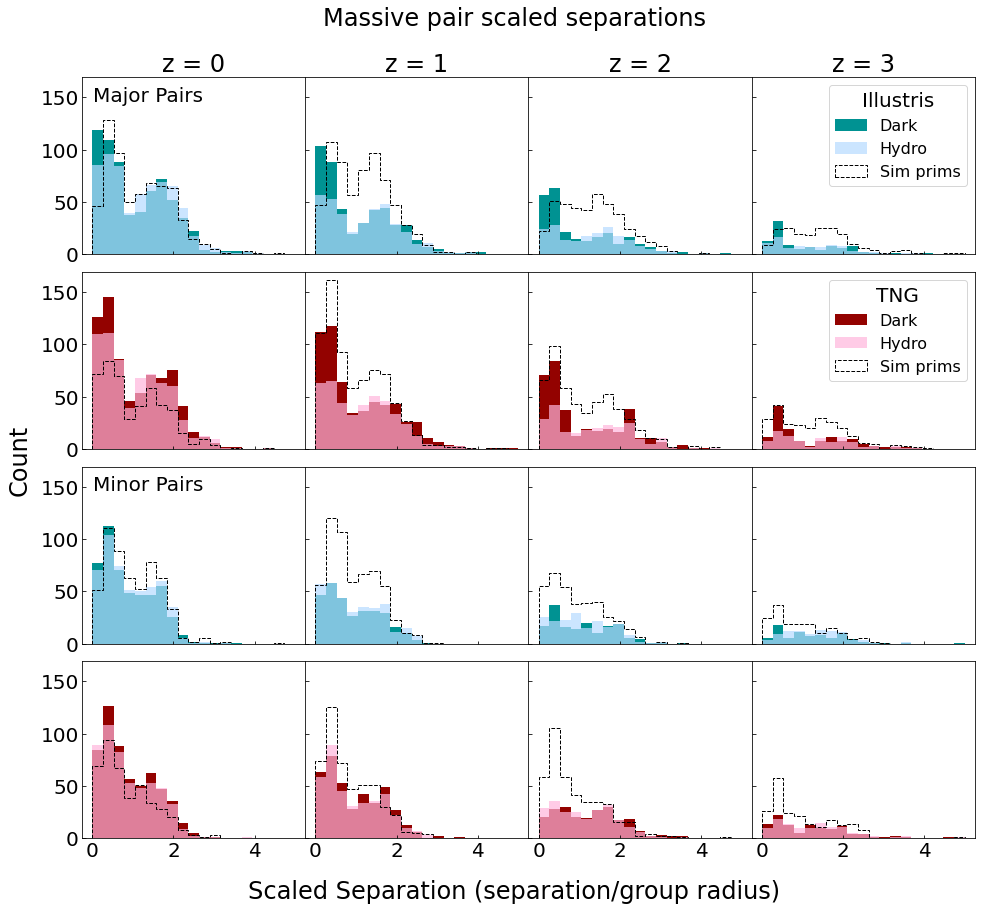

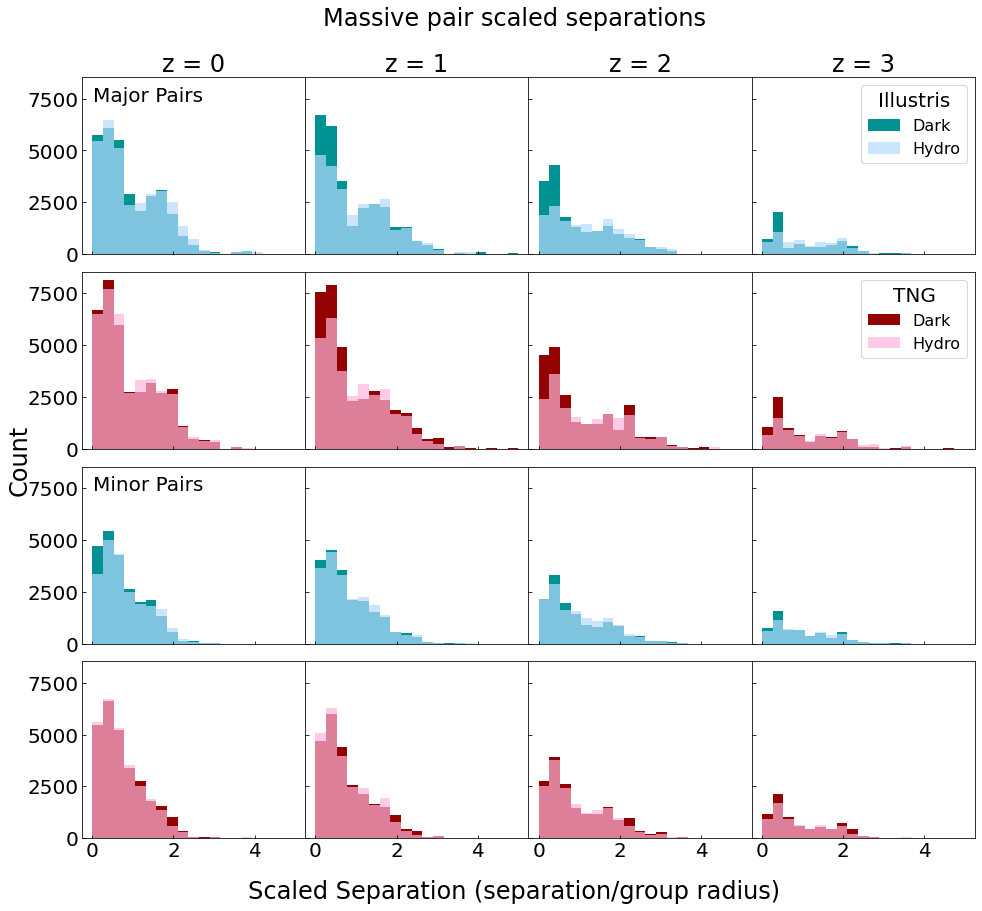

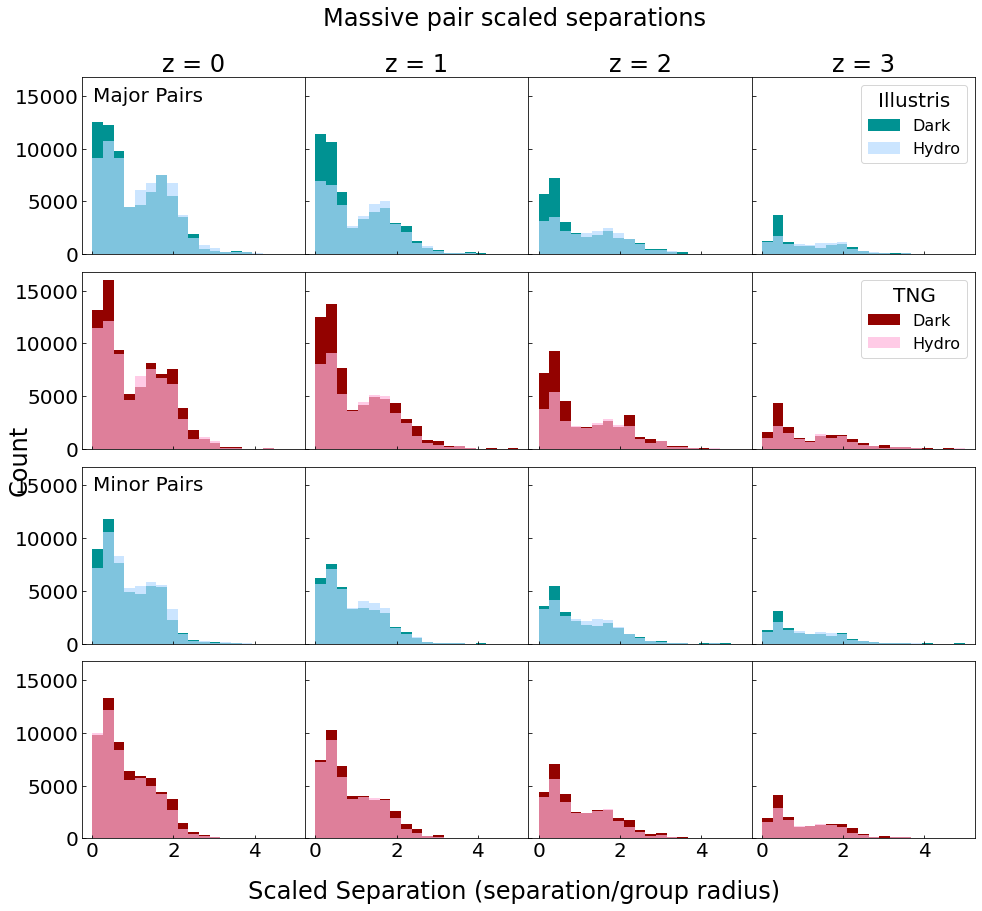

In [17]:
# Massive - scaled separation
for median_it in [True,False]:
    for group_it in [True,False]:

        fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
        plt.subplots_adjust(wspace=0,hspace=0.1)
        bins = np.linspace(0,5,20)
        weight = 1
        key = "Separation"
        size = "massive"
        kwargs_dict = {"median":median_it,
                       "groupCut": group_it,
                       "sepmask":"default"}

        if size == "dwarf":
            sizelabel = "d"
        elif size == "massive":
            sizelabel = "m"

        if kwargs_dict["median"]:
            medianlabel = "median"
        else:
            medianlabel = "allreals"

        if kwargs_dict["groupCut"]:
            grouplabel = "groupcut"
        else:
            grouplabel = "nogroupcut"

        for i in range(4):
            ax[0][i].set_title(f"z = {i}")

            illdsep = get_majmin("Illustris","dark", size, i, key, **kwargs_dict)
            illdrad = get_majmin("Illustris","dark", size, i, "Group Radius", **kwargs_dict)
            illhsep = get_majmin("Illustris","hydro", size, i, key, **kwargs_dict)
            illhrad = get_majmin("Illustris","hydro", size, i, "Group Radius", **kwargs_dict)
            tngdsep = get_majmin("TNG","dark", size, i, key, **kwargs_dict)
            tngdrad = get_majmin("TNG","dark", size, i, "Group Radius", **kwargs_dict)
            tnghsep = get_majmin("TNG","hydro", size, i, key, **kwargs_dict)
            tnghrad = get_majmin("TNG","hydro", size, i, "Group Radius", **kwargs_dict)


            illsimsep = get_majmin_simstell("Illustris", size, i, key, **kwargs_dict)
            illsimrad = get_majmin_simstell("Illustris", size, i, "Group Radius", **kwargs_dict)
            tngsimsep = get_majmin_simstell("TNG", size, i, key, **kwargs_dict)
            tngsimrad = get_majmin_simstell("TNG", size, i, "Group Radius", **kwargs_dict)
            
            # Illustris Major pairs
            ax[0][i].hist(illdsep['majors']/illdrad['majors'],weights=np.ones(len(illdsep['majors']))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
            ax[0][i].hist(illhsep['majors']/illhrad['majors'],weights=np.ones(len(illhsep['majors']))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')

            # TNG Major pairs
            ax[1][i].hist(tngdsep['majors']/tngdrad['majors'],weights=np.ones(len(tngdsep['majors']))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
            ax[1][i].hist(tnghsep['majors']/tnghrad['majors'],weights=np.ones(len(tnghsep['majors']))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')

            # Illustris Minor pairs
            ax[2][i].hist(illdsep['minors']/illdrad['minors'],weights=np.ones(len(illdsep['minors']))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
            ax[2][i].hist(illhsep['minors']/illhrad['minors'],weights=np.ones(len(illhsep['minors']))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')

            # TNG Minor pairs
            ax[3][i].hist(tngdsep['minors']/tngdrad['minors'],weights=np.ones(len(tngdsep['minors']))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
            ax[3][i].hist(tnghsep['minors']/tnghrad['minors'],weights=np.ones(len(tnghsep['minors']))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')


            if kwargs_dict['median']:
                ax[0][i].hist(illsimsep['majors']/illsimrad['majors'],weights=np.ones(len(illsimsep['majors']))/weight,histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
                ax[1][i].hist(tngsimsep['majors']/tngsimrad['majors'],weights=np.ones(len(tngsimsep['majors']))/weight,histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
                ax[2][i].hist(illsimsep['minors']/illsimrad['minors'],weights=np.ones(len(illsimsep['minors']))/weight,histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
                ax[3][i].hist(tngsimsep['minors']/tngsimrad['minors'],weights=np.ones(len(tngsimsep['minors']))/weight,histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

        ax[0][3].legend(title="Illustris",fontsize=16)
        ax[1][3].legend(title="TNG",fontsize=16)
        xlims, ylims = ax[0][0].get_xlim(), ax[0][0].get_ylim()
        xwidth, ywidth = np.diff(xlims), np.diff(ylims)


        ax[0][0].text(xlims[0]+0.05*xwidth,ylims[1]-0.05*ywidth,"Major Pairs",va='top')
        ax[2][0].text(xlims[0]+0.05*xwidth,ylims[1]-0.05*ywidth,"Minor Pairs",va='top')

        fig.suptitle("Massive pair scaled separations",y=0.95)
        fig.supxlabel(r"Scaled Separation (separation/group radius)",y=0.06)
        fig.supylabel("Count",x=0.060)

        plt.savefig(f"../plots/separations/scaledsepdist_{medianlabel}_{grouplabel}_{sizelabel}.png",bbox_inches='tight',facecolor="white")
        plt.show()

____
# Debug scratch graveyard etc etc 

In [21]:
kwarg_dict_def = {"groupCut": True, 
              "median":False, 
              "errorprint":False, 
              "redshiftcutoff":True}

In [31]:
import time

In [34]:
time.time()

1670368530.4135814

In [42]:
startt = time.time()
sim = "TNG"
groupCut=True
median=False
errorprint=False
redshiftcutoff=True
snap = 99
phys = 'hydro'
sepmask = "default"

if sim == "Illustris":
    snapshots = np.arange(0,136,1)
    snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
    redcutoff = 3.8
elif sim == "TNG":
    snapshots = np.arange(0,100,1)
    snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
    redcutoff = 4

redshifts = []  
med_pairs, med_major, med_minor = [], [], []
quart_pairs, quart_major, quart_minor = [], [], []

pair_path = f"{sim}_{snap}_100.hdf5"
pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")

redshift = pair_data['Header'].attrs['Redshift']

# grabbing the relevant values
pairs = pair_data["pairs"][phys]

pri_stell = np.array(pairs["Sub1 Stellar Mass"])
sec_stell = np.array(pairs["Sub2 Stellar Mass"])
grouprads = np.array(pairs["Group Radius"])
seps = np.array(pairs["Separation"]) 

# masks            
paired_prims = get_primmask(pri_stell, size)
paired_group = get_groupmask(np.array(pairs["Group Mass"]), size)
paired_median = np.array( pairs['Realization'] )==-1
paired_sepcut = get_sepmask(seps, key=sepmask, **{"groupRadius":grouprads})

majors = (sec_stell/pri_stell > 1/4)
minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

paired_mask = paired_prims & paired_sepcut

if groupCut:
    paired_mask = paired_mask & paired_group

if median:
    paired_mask = paired_mask & paired_median

    major_mask = paired_mask & majors
    minor_mask = paired_mask & minors

    med_pairs_snap = np.median(seps[paired_mask])
    med_major_snap = np.median(seps[major_mask])
    med_minor_snap = np.median(seps[minor_mask])
    quart_pairs_snap = [0,0]
    quart_major_snap = [0,0]
    quart_minor_snap = [0,0]

elif ~median: 
    paired_per_real = []
    major_per_real = []
    minor_per_real = []

    realizations = np.unique( np.array(pairs['Realization']) )

    for real in realizations:
        print(real)
        paired_real = np.array( pairs['Realization'] ) == real

        paired_mask_real = paired_mask & paired_real
        major_mask_real = paired_mask_real & majors
        minor_mask_real = paired_mask_real & minors

        if np.count_nonzero(paired_mask_real) == 0:
            pair_xx = 0
            major_xx = 0
            minor_xx = 0

        else: 
            pair_xx = np.median(seps[paired_mask_real])

            if np.count_nonzero(major_mask_real) == 0:
                major_xx = 0
            else:
                major_xx = np.median(seps[major_mask_real])

            if np.count_nonzero(minor_mask_real) == 0:
                minor_xx = 0
            else:
                minor_xx = np.median(seps[minor_mask_real])

        paired_per_real.append( pair_xx )
        major_per_real.append( major_xx )
        minor_per_real.append( minor_xx )

    med_pairs_snap = np.median(paired_per_real)
    med_major_snap = np.median(major_per_real)
    med_minor_snap = np.median(minor_per_real)
    quart_pairs_snap = np.percentile( paired_per_real,[16,84] ) 
    quart_major_snap = np.percentile( major_per_real,[16,84] ) 
    quart_minor_snap = np.percentile( minor_per_real,[16,84] ) 

redshifts.append( redshift )
med_pairs.append( med_pairs_snap )
med_major.append( med_major_snap )
med_minor.append( med_minor_snap )


quart_pairs.append( quart_pairs_snap )
quart_major.append( quart_major_snap )
quart_minor.append( quart_minor_snap )

endt = time.time()

dif = endt-startt
print(dif)

-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
0.8533010482788086


In [15]:
seps = get_seps("Illustris", "dark", "dwarf", sepmask="default")
    
# med = get_seps("Illustris", "dark", "dwarf", sepmask="default", median=True)

In [16]:
seps

{'z': array([3.70877426e+00, 3.49086137e+00, 3.28303306e+00, 3.08482264e+00,
        3.00813107e+00, 2.89578501e+00, 2.73314262e+00, 2.57729027e+00,
        2.44422570e+00, 2.31611074e+00, 2.20792547e+00, 2.10326965e+00,
        2.00202814e+00, 1.90408954e+00, 1.82268925e+00, 1.74357057e+00,
        1.66666956e+00, 1.60423452e+00, 1.53123903e+00, 1.47197485e+00,
        1.41409822e+00, 1.35757667e+00, 1.30237846e+00, 1.24847261e+00,
        1.20625808e+00, 1.15460271e+00, 1.11415056e+00, 1.07445789e+00,
        1.03551045e+00, 9.97294226e-01, 9.87852811e-01, 9.50531352e-01,
        9.23000816e-01, 8.86896938e-01, 8.51470901e-01, 8.16709979e-01,
        7.91068249e-01, 7.57441373e-01, 7.32636182e-01, 7.00106354e-01,
        6.76110411e-01, 6.44641841e-01, 6.21428745e-01, 5.98543288e-01,
        5.75980845e-01, 5.46392183e-01, 5.24565820e-01, 5.03047523e-01,
        4.81832943e-01, 4.60917794e-01, 4.40297849e-01, 4.19968942e-01,
        3.99926965e-01, 3.80167867e-01, 3.60687657e-01, 3.4

In [17]:
seps['medians']-med['medians']

KeyError: 'medians'

In [ ]:
pair_path = f"Illustris_135_10.hdf5"
pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")



# grabbing the relevant values
pairs = pair_data["pairs"][phys]

pri_stell = np.array(pairs["Sub1 Stellar Mass"])
sec_stell = np.array(pairs["Sub2 Stellar Mass"])
seps = np.array(pairs["Separation"]) 

In [ ]:
# masks            
paired_prims = get_primmask(pri_stell, "dwarf")
paired_group = get_groupmask(np.array(pairs["Group Mass"]), size)
paired_median = np.array( pairs['Realization'] )==-1
paired_sepcut = get_sepmask(seps)

majors = (sec_stell/pri_stell > 1/4)
minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

paired_mask = paired_prims & paired_sepcut

paired_mask = paired_mask & paired_group


In [ ]:
pairs = pair_data["pairs"][phys]

pri_stell = np.array(pairs["Sub1 Stellar Mass"])
sec_stell = np.array(pairs["Sub2 Stellar Mass"])
seps = np.array(pairs["Separation"]) 

# masks            
paired_prims = get_primmask(pri_stell, size)
paired_group = get_groupmask(np.array(pairs["Group Mass"]), size)
paired_median = np.array( pairs['Realization'] )==-1
paired_sepcut = get_sepmask(seps)

majors = (sec_stell/pri_stell > 1/4)
minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

paired_mask = paired_prims & paired_sepcut

In [ ]:
paired_mask = paired_mask & paired_group

paired_per_real = []
major_per_real = []
minor_per_real = []

realizations = np.unique( np.array(pairs['Realization']) )

In [ ]:
for real in realizations:
    paired_real = np.array( pairs['Realization'] ) == real

    paired_mask = paired_mask & paired_real
    major_mask = paired_mask & majors
    minor_mask = paired_mask & minors

    paired_per_real.append( np.median(seps[paired_mask]) )
    major_per_real.append( np.median(seps[major_mask]) )
    minor_per_real.append( np.median(seps[minor_mask]) )

med_pairs_snap = np.median(paired_per_real)
med_major_snap = np.median(major_per_real)
med_minor_snap = np.median(minor_per_real)
quart_pairs_snap = np.percentile( paired_per_real,[16,84] ) 
quart_major_snap = np.percentile( major_per_real,[16,84] ) 
quart_minor_snap = np.percentile( minor_per_real,[16,84] ) 

In [ ]:
paired_per_real

In [ ]:
redshifts.append( redshift )
med_pairs.append( med_pairs_snap )
med_major.append( med_major_snap )
med_minor.append( med_minor_snap )


quart_pairs.append( quart_pairs_snap )
quart_major.append( quart_major_snap )
quart_minor.append( quart_minor_snap )

In [ ]:
ill1 = get_seps("Illustris", "dark", "dwarf", groupCut=False)
ill2 = get_seps("Illustris", "dark", "dwarf", groupCut=True)
ill3 = get_seps("Illustris", "dark", "dwarf", **{"groupCut":True})

print(ill1['All Median']-ill2['All Median'])
print(ill1['All Median']-ill3['All Median'])
print(ill2['All Median']-ill3['All Median'])

In [ ]:
ill1

In [ ]:
kwarg_dict = {"groupCut": True, 
              "median":False, 
              "errorprint":False, 
              "redshiftcutoff":False,
              "sepmask":"default"}

illd = get_seps("TNG", "dark", "dwarf", **kwarg_dict)
illh = get_seps("TNG", "hydro", "dwarf", **kwarg_dict)